# Train transformer

In [1]:
import os
import math
import numpy as np

from tqdm.notebook import tqdm

import torch
import torch.nn as nn
from torch.nn import functional as F
from torch.nn.parallel import DistributedDataParallel as DDP
from torch.distributed import init_process_group, destroy_process_group
from torch.utils.checkpoint import checkpoint
from torch.utils.data import Dataset, DataLoader
from torch.optim.lr_scheduler import LambdaLR
import torch.ao.quantization as quantization
from torch.cuda.amp import GradScaler, autocast
import GPUtil
from contextlib import nullcontext

from bertviz import head_view, model_view


from transformer_implementation import TransformerConfig, DataLoaderFactory, LayerNorm, MultiHeadAttention, FeedForward
from utils import plot_losses

## Model

### DecoderBlock

In [2]:
class DecoderBlock(nn.Module):
    """
    A class that implements a single decoder block in the Transformer model.

    Each block consists of three sub-layers: a multi-head self-attention mechanism,
    a multi-head attention mechanism over the encoder's output, and a position-wise 
    fully connected feed-forward network. There is a residual connection around 
    each of the three sub-layers, followed by layer normalization.

    Attributes:
        - ln_1 (LayerNorm): Layer normalization before the first multi-head attention layer.
        - attn1 (MultiHeadAttention): First multi-head attention layer, with self-attention.
        - ln_2 (LayerNorm): Layer normalization before the second multi-head attention layer.
        - attn2 (MultiHeadAttention): Second multi-head attention layer, attends to encoder outputs.
        - ln_3 (LayerNorm): Layer normalization before the feed-forward network.
        - ffw (FeedForward): Position-wise feed-forward network.

    Args:
        config (Config): A configuration object with attribute `n_embd` and `bias`.
    """
    def __init__(self, config):
        super().__init__()
        self.ln_1 = LayerNorm(config.n_embd, bias=config.bias)
        self.attn1 = MultiHeadAttention(config)
        self.ln_2 = LayerNorm(config.n_embd, bias=config.bias)
        self.ffw = FeedForward(config)

    def forward(self, x, tgt_mask=None) -> torch.Tensor:
        """
        Defines the computation performed at every call.

        Args:
            - x (torch.Tensor): The input tensor to the forward pass.
            - tgt_mask (torch.Tensor, optional): The mask tensor to ignore padding, size (B, 1, 1, T).

        Returns:
            - torch.Tensor: The output tensor of the block.
            - encoder_attn: The encoder attention weight of the current block.
        """
        # Masked MultiHeadAttention
        x = self.ln_1(x)
        x_attn, encoder_attn = checkpoint(self.attn1, x, x, x, tgt_mask, True)
        x = self.ln_2(x + x_attn)
        # FeedForward
        x = x + checkpoint(self.ffw, x)
        return x, encoder_attn

### Decoder

In [3]:
class Decoder(nn.Module):
    """
    This class implements the decoder part of the Transformer model.

    The Decoder consists of several DecoderBlocks arranged in sequence. The input first goes through an embedding 
    layer followed by a positional encoding layer. The output of this is then passed through each DecoderBlock in 
    sequence.

    Attributes:
        - decoder (nn.ModuleDict): A dictionary of modules making up the transformer decoder.
        - lm_head (nn.Linear): The final linear layer mapping from the embedding dimension to the vocabulary size.
        - config (:obj:`Config`): The configuration object for the transformer model.

    .. note:: The weight of the embedding layer and the linear layer are shared.

    Args:
        - config (:obj:`Config`): The configuration object with attributes such as `vocab_size`, `block_size`, `n_embd`, `dropout`, `n_layer`, and `bias`.
    """

    def __init__(self, config):
        super().__init__()
        assert config.vocab_size is not None
        assert config.block_size is not None
        self.config = config

        self.decoder = nn.ModuleDict(dict(
            wte = nn.Embedding(config.vocab_size, config.n_embd),
            wpe = nn.Embedding(config.block_size, config.n_embd),
            drop = nn.Dropout(config.dropout),
            h = nn.ModuleList([DecoderBlock(config) for _ in range(config.n_layer)]),
            ln_f = LayerNorm(config.n_embd, bias=config.bias),
        ))
        self.lm_head = nn.Linear(config.n_embd, config.vocab_size, bias=False)
        # with weight tying when using torch.compile() some warnings get generated:
        # "UserWarning: functional_call was passed multiple values for tied weights.
        # This behavior is deprecated and will be an error in future versions"
        # not 100% sure what this is, so far seems to be harmless. TODO investigate
        self.decoder.wte.weight = self.lm_head.weight # https://paperswithcode.com/method/weight-tying

        # init all weights
        self.apply(self._init_weights)
        # apply special scaled init to the residual projections, per GPT-2 paper
        for pn, p in self.named_parameters():
            if pn.endswith('c_proj.weight'):
                torch.nn.init.normal_(p, mean=0.0, std=0.02/math.sqrt(2 * config.n_layer))

        # report number of parameters
        print("number of Decoder parameters: %.2fM" % (self.get_num_params()/1e6,))

    def get_num_params(self, non_embedding: bool = True) -> int:
        """
        Returns the number of parameters in the model.
        For non-embedding count (default), the position embeddings get subtracted.
        The token embeddings would too, except due to the parameter sharing these
        params are actually used as weights in the final layer, so we include them.

        Args:
            - non_embedding (bool): If True, excludes the position embeddings count from the total. Default is True.

        Returns:
            - int: The number of parameters in the model.
        """
        n_params = sum(p.numel() for p in self.parameters())
        if non_embedding:
            n_params -= self.decoder.wpe.weight.numel()
        return n_params

    def _init_weights(self, module):
        """
        Initializes the weights of the model.

        Args:
            - module (torch.nn.Module): The module of the model to be initialized.
        """
        if isinstance(module, nn.Linear):
            # init Linear layers with normal distribution (Gaussian initialization)
            torch.nn.init.normal_(module.weight, mean=0.0, std=0.02)
            if module.bias is not None:
                # bias initialization if necessary
                torch.nn.init.zeros_(module.bias)
        elif isinstance(module, nn.Embedding):
            # init Embedding layers with normal distribution (Gaussian initialization)
            torch.nn.init.normal_(module.weight, mean=0.0, std=0.02)

    def forward(self, idx, tgt_mask=None):
        """
        Defines the computation performed at every call.

        Args:
            - idx (torch.Tensor): The input tensor to the forward pass.
            - tgt_mask (torch.Tensor, optional): The mask tensor to ignore padding, size (B, 1, 1, T).

        Returns:
            - torch.Tensor: The output tensor (logits) of the model.
            - list: all layers of decoder attentions weights.
        """
        device = idx.device
        b, t = idx.size()
        
        pos = torch.arange(0, t, dtype=torch.long, device=device) # shape (t)
        tok_emb = self.decoder.wte(idx) # token embeddings of shape (b, t, n_embd)
        pos_emb = self.decoder.wpe(pos) # position embeddings of shape (t, n_embd)
        x = self.decoder.drop(tok_emb + pos_emb) # Addition of input embd + positional encoding

        decoder_attn_all = []
        for block in self.decoder.h:
            x, encoder_attn = block(x, tgt_mask)
            decoder_attn_all.append(encoder_attn)
            
        x = self.decoder.ln_f(x)
        return self.lm_head(x), decoder_attn_all

### MiniGpt

In [4]:
class MiniGPT(nn.Module):
    """
    This class implements the Transformer model, which includes both the encoder and decoder.

    The Transformer is a sequence transduction model that uses attention mechanisms.
    It is primarily used in tasks that require understanding of context or relationships among words in a text.

    Attributes:
        - decoder (Decoder): The transformer decoder.
        - config (:obj:`Config`): The configuration object for the transformer model.

    Args:
        - config (:obj:`Config`): The configuration object with attributes such as `vocab_size`, `block_size`, `n_embd`, `dropout`, `n_layer`, and `bias`.
    """
    def __init__(self, config):
        super().__init__()
        assert config.vocab_size is not None
        assert config.block_size is not None
        self.config = config
        self.decoder = Decoder(config)

    def forward(self, tgt, tgt_tgt=None, tgt_mask=None):
        """
        Defines the computation performed at every call.

        Args:
            - tgt (torch.Tensor): The input tensor to the decoder.
            - tgt_mask (torch.Tensor): The target_masks tensor to the decoder, size (B, 1, 1, T).

        Returns:
            - torch.Tensor: The output tensor (logits) of the model.
            - torch.Tensor: The loss tensor calculated on the basis of the decoder's output and target tensor.
        """
        assert tgt.dim() == 2, "tgt should be 2D (B, S)"
        if tgt_mask is not None:
            assert tgt_mask.dim() == 4, "tgt_mask should be 4D (B, 1, 1 S)"

        output, _, = self.decoder(tgt, tgt_mask)

        if tgt_tgt is None:
            loss = None
        else:
            B, T, C = output.shape
            output = output.view(B*T, C)
            tgt_tgt = tgt_tgt.view(B*T)
            # Calculate the loss, using both the output and the target
            loss_fct = nn.CrossEntropyLoss(ignore_index=self.config.PAD_IDX) # Ignore padding tokens
            loss = loss_fct(output, tgt_tgt)
            
        return output, loss

    @torch.no_grad()
    def generate(self, idx, max_new_tokens, temperature=1.0, top_k=None):
        # idx is (B, T) array of indices in the current context
        for _ in range(max_new_tokens):
            # crop idx to the last block_size tokens
            idx_cond = idx if idx.size(1) <= self.config.block_size else idx[:, -self.config.block_size:]
            # get the predictions
            logits, decoder_attn_all = self.decoder(idx_cond)
            # focus only on the last time step
            logits = logits[:, -1, :] / temperature # becomes (B, C)
            # optionally crop the logits to only the top k options
            if top_k is not None:
                v, _ = torch.topk(logits, min(top_k, logits.size(-1)))
                logits[logits < v[:, [-1]]] = -float('Inf')
            # apply softmax to get probabilities
            probs = F.softmax(logits, dim=-1) # (B, C)
            # sample from the distribution
            idx_next = torch.multinomial(probs, num_samples=1) # (B, 1)
            # append sampled index to the running sequence
            idx = torch.cat((idx, idx_next), dim=1) # (B, T+1)
        return idx, decoder_attn_all

    def configure_optimizers(self, weight_decay, learning_rate, betas, device_type, eps):
        # start with all of the candidate parameters
        param_dict = {pn: p for pn, p in self.named_parameters()}
        # filter out those that do not require grad
        param_dict = {pn: p for pn, p in param_dict.items() if p.requires_grad}
        # create optim groups. Any parameters that is 2D will be weight decayed, otherwise no.
        # i.e. all weight tensors in matmuls + embeddings decay, all biases and layernorms don't.
        decay_params = [p for n, p in param_dict.items() if p.dim() >= 2]
        nodecay_params = [p for n, p in param_dict.items() if p.dim() < 2]
        optim_groups = [
            {'params': decay_params, 'weight_decay': weight_decay},
            {'params': nodecay_params, 'weight_decay': 0.0}
        ]
        num_decay_params = sum(p.numel() for p in decay_params)
        num_nodecay_params = sum(p.numel() for p in nodecay_params)
        print(f"num decayed parameter tensors: {len(decay_params)}, with {num_decay_params:,} parameters")
        print(f"num non-decayed parameter tensors: {len(nodecay_params)}, with {num_nodecay_params:,} parameters")
        optimizer = torch.optim.AdamW(optim_groups, lr=learning_rate, betas=betas, eps=eps)

        return optimizer
        
    def save_model(self, path: str):
        """
        Saves the current state of the model to a file.

        Args:
            path (str): The path to the file where the model state should be saved.
        """
        torch.save(self.state_dict(), path)

    def load_model(self, path: str):
        """
        Loads the model state from a file.

        Args:
            path (str): The path to the file from where the model state should be loaded.

        Raises:
            ValueError: If the specified file does not exist.
        """
        if not os.path.exists(path):
            raise ValueError(f"{path} does not exist.")
        self.load_state_dict(torch.load(path))

### Tokenizer

In [5]:
class dotdict(dict):
    """dot.notation access to dictionary attributes"""
    __getattr__ = dict.get
    __setattr__ = dict.__setitem__
    __delattr__ = dict.__delitem__

In [6]:
class Tokenizer():
    """A tokenizer class for encoding/decoding text sequences."""

    def __init__(self):
        """
        Constructor method to initialize special token indices and tokenizer encoding. 
        """
        # Initialize special token indices
        self.BOS_IDX: int = 100264  # Index for the Beginning of Sentence token
        self.EOS_IDX: int = 100265  # Index for the End of Sentence token
        self.PAD_IDX: int = 100266  # Index for the Padding token

        
        with open('./data/input.txt', 'r', encoding='utf-8') as f:
            text = f.read()
        
        self.chars = sorted(list(set(text)))
        # create a mapping from characters to integers
        self.stoi = { ch:i for i,ch in enumerate(self.chars) }
        self.itos = { i:ch for i,ch in enumerate(self.chars) }
        
        # Initialize the tokenizer's encoding with special tokens added
        self.encoder = dotdict({
            'encode': lambda s: [self.stoi[c] for c in s], # encoder: take a string, output a list of integers
            'decode': lambda l: ''.join([self.itos[i] for i in l]) # decoder: take a list of integers, output a string
        })

    def vocab_size(self):
        return len(self.chars)
        
    def sequence_padding(self, sequence, max_size: int = 512, device: str = "cpu") -> torch.Tensor:
        """
        Method to add BOS/PAD/EOS special tokens and ensure the sequence length is within the maximum size.

        Args:
            sequence (torch.Tensor or list): The input sequence.
            max_size (int, optional): The maximum allowed size for the sequence. Defaults to 512.
            device (str, optional): The device where the tensors will be allocated. Defaults to "cpu".

        Returns:
            torch.Tensor: The processed sequence with special tokens added and length limited.
        """
        assert max_size > 2, f"[max_size]: {max_size} should be greater than 2"
        # Ensure the sequence is a torch tensor
        tensor_sequence = torch.tensor(sequence, dtype=torch.long).to(device) if not torch.is_tensor(sequence) else sequence.to(device)

        # Limit the sequence length within (max_size - 2) where 2 corresponding to bos and eos tags
        cutted_sequence_size = max(0, min(max_size - 2, tensor_sequence.size()[0]))
        tensor_sequence = tensor_sequence[:cutted_sequence_size]
        
        # Add BOS token
        tensor_sequence = torch.cat([torch.tensor([self.BOS_IDX], dtype=torch.long, device=device), tensor_sequence], dim=0)

        # Calculate the padding size
        padding_size = max_size - tensor_sequence.size()[0] - 1 # expected size - current size - EOS tag

        # Create PAD tensor
        pad_tensor = torch.full((padding_size,), self.PAD_IDX, dtype=torch.long, device=device)

        # Add PAD and EOS tokens
        tensor_sequence = torch.cat([tensor_sequence, torch.tensor([self.EOS_IDX], dtype=torch.long, device=device), pad_tensor], dim=0)
        
        return tensor_sequence
    
    def sequence_cleaner(self, sequence):
        """ Method used to remove BOS/PAD/EOS special tokens """
        # Checking tensor format
        list_sequence = sequence.tolist() if torch.is_tensor(sequence) else sequence
        def check_special(number):
            return number not in [self.BOS_IDX, self.EOS_IDX, self.PAD_IDX]
        return list(filter(check_special, list_sequence))

    def generate_padding_mask(self, seq, triu = False, device="cpu"):
        # seq shape is (B, T) where B is batch size and T is sequence length
        # padding mask should be of size (B, 1, 1, T), mask should be True for padding tokens and False for others
        mask = (seq != self.PAD_IDX).unsqueeze(0).unsqueeze(0).to(device)
        if triu:
            seq_length = seq.size(-1)
            nopeak_mask = (1 - torch.triu(torch.ones(1, seq_length, seq_length), diagonal=1)).bool().to(device)
            mask = mask & nopeak_mask
        return mask.to(device)

    def tokenize(self, sequence, device="cpu") -> list:
        """
        Method to generate a str list of separated tokens token.

        Args:
            sequence (torch.Tensor or list): The input sequence.
            device (str, optional): The device where the tensors will be allocated. Defaults to "cpu".

        Returns:
            list: The processed sequence converted in a list of tokens in string format.
        """
        # Ensure the sequence is a torch tensor
        tensor_sequence = torch.tensor(sequence, dtype=torch.long).to(device) if not torch.is_tensor(sequence) else sequence.to(device)
        # create batch of idx tokens
        tensor_sequence = tensor_sequence.unsqueeze(0).T
        # decode all batch to recreate list of separated tokens 
        tensor_sequence = self.encoder.decode_batch(tensor_sequence.detach().tolist())
        return tensor_sequence

    def tokenize_from_str(self, sequence, device="cpu") -> list:
        return self.tokenize(self.encoder.encode(sequence), device)

## Init
### Tokenizer

In [7]:
# init tokenizer
tokenizer = Tokenizer()

### Config

In [8]:
## init config
config = TransformerConfig(
    vocab_size = tokenizer.vocab_size(),
    n_layer = 6, # 6,
    n_head = 6,
    n_embd = 384,
    max_epochs= 300, # 1000,
	dropout=0.2,
    train_data_size = 30000, # batch * 500 iters
    max_iters = int(4015360/64/256)-1, # dataset_size / batch_size / block_size
    eval_iters = int(445952/64/256)-1, # val_dataset_size / batch_size / block_size
    BOS_IDX = tokenizer.BOS_IDX,
    EOS_IDX = tokenizer.EOS_IDX,
    PAD_IDX = tokenizer.PAD_IDX,
)

#### Multi Process config

In [9]:
if config.ddp:
    init_process_group(backend=config.backend)
    ddp_rank = int(os.environ['RANK'])
    ddp_local_rank = int(os.environ['LOCAL_RANK'])
    ddp_world_size = int(os.environ['WORLD_SIZE'])
    config.device = f'cuda:{ddp_local_rank}'
    torch.cuda.set_device(device)
    master_process = ddp_rank == 0 # this process will do logging, checkpointing etc.
    seed_offset = ddp_rank # each process gets a different seed
    # world_size number of processes will be training simultaneously, so we can scale
    # down the desired gradient accumulation iterations per process proportionally
    assert gradient_accumulation_steps % ddp_world_size == 0
    config.gradient_accumulation_steps //= ddp_world_size
else:
    # if not ddp, we are running on a single gpu, and one process
    master_process = True
    seed_offset = 0
    ddp_world_size = 1

torch.manual_seed(1337 + seed_offset)
torch.backends.cuda.matmul.allow_tf32 = True # allow tf32 on matmul
torch.backends.cudnn.allow_tf32 = True # allow tf32 on cudnn
# note: float16 data type will automatically use a GradScaler
ptdtype = {'float32': torch.float32, 'bfloat16': torch.bfloat16, 'float16': torch.float16}[config.dtype]
ctx = nullcontext() if config.device_type == 'cpu' else torch.amp.autocast(device_type=config.device_type, dtype=ptdtype)


gpu_ok = False
if torch.cuda.is_available():
    device_cap = torch.cuda.get_device_capability()
    if device_cap in ((7, 0), (8, 0), (9, 0)):
        gpu_ok = True

if not gpu_ok:
    print(
        "GPU is not NVIDIA V100, A100, or H100. Speedup numbers may be lower than expected."
    )
config.compile = gpu_ok

GPU is not NVIDIA V100, A100, or H100. Speedup numbers may be lower than expected.


In [10]:
print(config)

TransformerConfig:

Tokenizer:
+---------------------+
| vocab_size : 65     |
| BOS_IDX    : 100264 |
| EOS_IDX    : 100265 |
| PAD_IDX    : 100266 |
+---------------------+

Data:
+---------------------------------+
| block_size              : 256   |
| batch_size              : 12    |
| train_data_size         : 30000 |
| grad_accumulation_steps : 40    |
+---------------------------------+

Model:
+-----------------+
| n_layer : 6     |
| n_head  : 6     |
| n_embd  : 384   |
| dropout : 0.2   |
| bias    : 0     |
+-----------------+

Training Loop:
+------------------+
| max_epochs : 300 |
| max_iters  : 244 |
| eval_iters : 26  |
+------------------+

AdamW Optimizer:
+------------------------+
| learning_rate : 0.0006 |
| beta1         : 0.9    |
| beta2         : 0.95   |
| weight_decay  : 0.1    |
| eps           : 1e-09  |
+------------------------+

System:
+-----------------------+
| device_type : cuda    |
| device      : cuda    |
| dtype       : float16 |
| compile    

### Loading dataset

In [11]:
class TranslationDataset(Dataset):
    """
    A PyTorch Dataset class to be used in a PyTorch DataLoader to create batches.

    Args:
        - dataset (Dataset): a dataset from HuggingFace datasets library.
        - tokenizer (Tokenizer): The custom tiktoken tokenizer used to encode sequences.
        - block_size (int): The maximum sequence length for tokenization.
    """

    def __init__(self, dataset, tokenizer, block_size):
        self.dataset = dataset
        self.tokenizer = tokenizer
        self.block_size = block_size

    def __getitem__(self, index):
        """
        Get a tokenized example from the dataset at the specified index.

        Args:
            - index (int): the index of the example to fetch.

        Returns:
            - Dict: dictionary with keys 'inputs', 'inputs_mask', 'targets' , 'targets_mask' and 'translation', containing tokenized input,
            target sequences and original translation.
        """
        x = self.dataset[index:index+self.block_size]
        y = self.dataset[index+1:index+self.block_size+1]

        if len(x) < self.block_size or len(y) < self.block_size:
            d_size = len(self.dataset)
            x = self.dataset[d_size-(self.block_size+1):d_size-1]
            y = self.dataset[d_size-self.block_size:d_size]
        
        return {
            'x': x,
            'y': y,
        }

    def __len__(self) -> int :
        """
        Returns the length of the dataset.

        Returns:
            - int: the length of the dataset.
        """
        return len(self.dataset)

class DataLoaderFactory():
    """
    A class to instantiate PyTorch DataLoaders for different splits of a HuggingFace Dataset.

    Args:
        - block_size (int): The maximum sequence length for tokenization.
        - batch_size (int): The batch size for DataLoader.
        - tokenizer (Tokenizer): a tokenizer that has an encode method.
        - device (str): 'cpu' or 'cuda', depending on whether we use CPU or GPU.
    """

    def __init__(self, block_size, batch_size, tokenizer, device):
        self.block_size = block_size
        self.batch_size = batch_size
        self.tokenizer = tokenizer
        self.device = device
        
        self.text, self.train_data, self.val_data = self.__load_data()
        
        self.dataloader_train = DataLoader(self.train_data, batch_size=batch_size, shuffle=True)
        self.dataloader_val = DataLoader(self.val_data, batch_size=batch_size, shuffle=True)
        
    def __load_data(self):
        with open('./data/input.txt', 'r', encoding='utf-8') as f:
            text = f.read()
        dataset = torch.tensor(tokenizer.encoder.encode(text), dtype=torch.long)
        n = int(0.9*len(dataset)) # first 90% will be train, rest val
        t_data = dataset[:n]
        v_data = dataset[n:]
        train_data = TranslationDataset(t_data[:(len(t_data)//self.block_size)*self.block_size], self.tokenizer, self.block_size)
        val_data = TranslationDataset(v_data[:(len(v_data)//self.block_size)*self.block_size], self.tokenizer, self.block_size)
        return text, train_data, val_data
        
    def __len__(self) -> int :
        """
        Print the length of each dataset and returns the length of all datasets.

        Returns:
            - int: the length of all dataset (train + val + test).
        """
        print("\033[95m\033[1m\033[4mNumber of data by datasets splits\033[0m")
        print(f"Train\t\t: {len(self.train_data)}\t-> {len(self.train_data)/self.batch_size/self.block_size}")
        print(f"Validation\t: {len(self.val_data)}\t\t-> {len(self.val_data)/self.batch_size/self.block_size}")
        total = len(self.train_data) + len(self.val_data)
        print(f"Total\t\t: {total}")
        return total

    def get_batch(self, split):
        """
        Choose the correct DataLoader and yield batches from it.

        Args:
            - split (str): 'train', 'val' or 'test'.

        Yields:
            - Dict: a dictionary with keys 'inputs', 'targets' and 'translation', containing a batch of tokenized input,
            target sequences and original translation.
        """
        # choose the correct dataloader
        if split == 'train':
            dataloader = self.dataloader_train
        else:
            dataloader = self.dataloader_val

        for batch in dataloader:
            # Move tensors to device
            batch_on_device = {k: v.to(self.device) for k, v in batch.items()}
            yield batch_on_device

In [12]:
# loading dataset
dataset = DataLoaderFactory(config.block_size, config.batch_size, tokenizer, config.device)
len(dataset)

Number of data by datasets splits
Train		: 4015360	-> 1307.0833333333333
Validation	: 445952		-> 145.16666666666666
Total		: 4461312


4461312

In [13]:
# batch = dataset.get_batch('train')
# next_batch = next(batch)

In [14]:
# print(tokenizer.encoder.decode(next_batch['x'][0].tolist()))
# print('-----')
# print(tokenizer.encoder.decode(next_batch['y'][0].tolist()))
# assert "a" == "b"

In [15]:
# for x in next_batch['x']:
#     print('-----')
#     print(tokenizer.encoder.decode(x.tolist()))

## Utils

In [16]:

@torch.no_grad()
def estimate_loss(model, dataset, config, splits = ['train', 'val']):
    """
    This function estimates the loss of a model on specified data splits without performing backpropagation.
    It sets the model to evaluation mode, iterates over the data splits and calculates the average loss.

    Args:
        model (Transformer): The model for which loss needs to be estimated.
        dataset (CustomDataset): The dataset used for estimation. It should provide a 'get_batch' method.
        config (Config): The configuration object defining the number of evaluation iterations.
        splits (list[str]): List of the names of data splits to use for estimation.

    Returns:
        out (dict): A dictionary with split names as keys and corresponding average loss as values.
    """
    # Create an empty dictionary to store the average loss for each split
    out = {}

    # Set the model to evaluation mode
    model.eval()

    # Loop over the data splits
    for split in splits:
        # Initialize a tensor to store the losses for each iteration in the current split
        losses = torch.zeros(config.eval_iters)

        # Get a batch iterator for the current split
        batch = dataset.get_batch(split)
        
        # Initialize a progress bar for the inner loop
        inner_loop = tqdm(range(config.eval_iters), desc=f"Evaluation - {split}", leave=False)

        # Start the inner loop
        for k in inner_loop:
            # Sample a new batch of data
            n_batch = next(batch)
            X = n_batch['x']
            Y = n_batch['y']
            
            # Evaluate the loss for the current batch
            with ctx:
                logits, loss = model(X, Y)

            # Store the current loss
            losses[k] = loss.item()
            
        # Calculate and store the mean loss for the current split
        out[split] = losses.mean()

    # Return the dictionary with the average losses
    return out

### Model

#### Initial gpu usage:

In [17]:
def get_gpu_memory():
    GPUs = GPUtil.getGPUs()
    gpu = GPUs[0]
    return gpu.memoryUsed

In [18]:
print(f"Initial GPU Memory Used: {get_gpu_memory()} MB")

Initial GPU Memory Used: 761.0 MB


In [19]:
# Create model
model = MiniGPT(config)
model.train()
model = model.to(config.device)

# for Accumulating Gradients for Larger Effective Batch Size. If enabled=False scaler is a no-op
scaler = GradScaler(enabled=(config.dtype == 'float16')) # Initialize GradScaler

# create a PyTorch optimizer
# optimizer = torch.optim.AdamW(model.parameters(), lr=config.learning_rate, betas=(0.9, 0.98), eps=1e-9)
optimizer = model.configure_optimizers(weight_decay=config.weight_decay, learning_rate=config.learning_rate, betas=(config.beta1, config.beta2), eps=config.eps, device_type=config.device_type)

# compile the model
if config.compile:
    print("compiling the model... (takes a ~minute)")
    unoptimized_model = model
    model = torch.compile(model) # requires PyTorch 2.0

# wrap model into DDP container
if config.ddp:
    model = DDP(model, device_ids=[ddp_local_rank])

number of Decoder parameters: 10.65M
num decayed parameter tensors: 38, with 10,740,096 parameters
num non-decayed parameter tensors: 13, with 4,992 parameters


#### GPU after Loading Model

In [20]:
print(f"GPU Memory Used After Loading Model: {get_gpu_memory()} MB")

GPU Memory Used After Loading Model: 901.0 MB


In [21]:
CALCULATE_MEMORY = False
if CALCULATE_MEMORY:
    # Get the initial memory usage
    initial_memory = get_gpu_memory()
    
    batch = dataset.get_batch('train')
    
    for i in range(5):
        n_batch = next(batch)
        xb = n_batch['x']
        yb = n_batch['y']

        # autocast means part of the model run in FP16 to save memory
        with autocast():
            # Forward pass
            logits, loss = model(xb, yb)
        
        # Calculate the memory used
        memory_used = get_gpu_memory() - initial_memory
        
        print(f"Memory used for a batch {i}: {memory_used} MB")
        
        # Make sure to zero out the gradients and free the memory
        model.zero_grad()
        torch.cuda.empty_cache()
    assert "a" == "b"

**Memory History: Before Quantization 6198.0 MB**

## Training

### Loop

In [22]:
# learning rate warmup and then decay, which is a standard practice in Transformer training.
def get_linear_schedule_with_warmup(optimizer, num_warmup_steps, num_training_steps):
    """ "warm-up, then decay" strategy. """
    def lr_lambda(current_step):
        if current_step < num_warmup_steps:
            return float(current_step) / float(max(1, num_warmup_steps))
        return max(0.0, float(num_training_steps - current_step) / float(max(1, num_training_steps - num_warmup_steps)))

    return LambdaLR(optimizer, lr_lambda)

def training_loop(model, optimizer, dataset, config, saved_path = "./out/minigpt_state222_dict.pth"):
    """
    This function performs the training loop for the given transformer model. It trains the model using the provided 
    optimizer and dataset according to the specified configuration. 

    Args:
        - model (Transformer): The transformer model to be trained.
        - optimizer (torch.optim.Optimizer): The optimizer used to update the model's parameters.
        - dataset (CustomDataset): The dataset used for training and validation. It should provide a 'get_batch' method.
        - config (Config): The configuration object that defines parameters like max_iters.

    Returns:
        - losses_list (dict): A dictionary that contains the training and validation losses per evaluation step.
    """
    raw_model = model.module if config.ddp else model # unwrap DDP container if needed
    # This is the total number of training steps,
    # which is typically the number of training examples times the number of epochs.
    num_training_steps = config.train_data_size * config.max_epochs
    # Choose warmup_steps such that it's 1% of total steps
    num_warmup_steps = num_training_steps // 100
    # You can add this after defining your optimizer
    scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps, num_training_steps)
    # Initialize a dictionary to keep track of training and validation losses
    losses_list = {
        'train': [],
        'val': [],
    }
    
    # Initialize minimum loss with a high value and the iteration number where the minimum was observed
    iter_saved = 0

    # init early stop
    best_loss = float('inf')
    val_loss = float('inf')
    # This is the number of epochs with no improvement after which training will be stopped.
    patience = 50
    # This is used to keep track of the number of epochs without improvement.
    patience_counter = 0

    # Initialize a progress bar for the outer training loop
    outer_loop = tqdm(range(config.max_epochs), desc="Train loss nan, Val loss nan, Saved nan", leave=True)

    # Start the training loop
    for epochs in outer_loop:
        # Initialize a batch of data from the 'train' part of the dataset
        iter_loop = tqdm(range(config.max_iters), leave=False)
        batch = dataset.get_batch('train')
        for iter in iter_loop:
            # Sample a new batch of data
            n_batch = next(batch)
            xb = n_batch['x']
            yb = n_batch['y']

            
            if config.ddp:
                # in DDP training we only need to sync gradients at the last micro step.
                # the official way to do this is with model.no_sync() context manager, but
                # I really dislike that this bloats the code and forces us to repeat code
                # looking at the source of that context manager, it just toggles this variable
                model.require_backward_grad_sync = ((iter+1) % config.grad_accumulation_steps == 0)
            with ctx:
                # Evaluate the loss
                logits, loss = model(xb, yb)
                loss = loss / config.grad_accumulation_steps # scale the loss to account for gradient accumulation
            
            # # Reset gradients
            # optimizer.zero_grad(set_to_none=True)
            # # Perform backpropagation
            # loss.backward()
            # # Update the model parameters
            # optimizer.step()
            # # update sheduler
            # scheduler.step()

        
            # Performs the backward pass with gradient scaling.
            scaler.scale(loss).backward()

            # Gradient Accumulation over multiple batches
            if (iter+1) % config.grad_accumulation_steps == 0:
                # Unscales the gradients of optimizer's assigned params in-place
                scaler.unscale_(optimizer)
                
                # Since the gradients of optimizer's assigned params are unscaled, clips as usual:
                torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
                
                # optimizer.step() is now replaced with scaler.step(optimizer)
                scaler.step(optimizer)
                
                # Updates the scale for next iteration.
                scaler.update()
                
                # Don't forget to zero the grad again after performing optimizer.step()
                optimizer.zero_grad(set_to_none=True)
                
                # update sheduler
                scheduler.step()

        ############
        # Evaluation
        ############
        # Estimate the losses for both training and validation datasets
        losses = estimate_loss(model, dataset, config)
        # Return the model to training mode
        model.train()
        
        # Record the estimated losses
        losses_list['train'].append(losses['train'])
        losses_list['val'].append(losses['val'])
                    
        # Get the latest losses
        last_loss_train = losses_list['train'][-1]
        last_loss_val = losses_list['val'][-1]
        
        ############
        # early stop
        ############
        val_loss = losses['val']
        if val_loss < best_loss:
            torch.save(raw_model.state_dict(), saved_path)
            best_loss = val_loss
            patience_counter = 0
            iter_saved = epochs
        else:
            patience_counter += 1

        # Update the description of the progress bar
        outer_loop.set_description(f"Train loss {last_loss_train:.4f}, Val loss {last_loss_val:.4f}, Saved {iter_saved}")
        
        if patience_counter >= patience:
            print("Early stopping")
            break
    
    # Return the list of losses
    return losses_list

In [23]:
losses_list = training_loop(model, optimizer, dataset, config)

Train loss nan, Val loss nan, Saved nan:   0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/244 [00:00<?, ?it/s]

Evaluation - train:   0%|          | 0/26 [00:00<?, ?it/s]

C:\Users\thiba\.virtualenvs\transformer-LWcVpt7F\Lib\site-packages\torch\utils\checkpoint.py:31: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradients will be None")


Evaluation - val:   0%|          | 0/26 [00:00<?, ?it/s]

  0%|          | 0/244 [00:00<?, ?it/s]

Evaluation - train:   0%|          | 0/26 [00:00<?, ?it/s]

Evaluation - val:   0%|          | 0/26 [00:00<?, ?it/s]

  0%|          | 0/244 [00:00<?, ?it/s]

Evaluation - train:   0%|          | 0/26 [00:00<?, ?it/s]

Evaluation - val:   0%|          | 0/26 [00:00<?, ?it/s]

  0%|          | 0/244 [00:00<?, ?it/s]

Evaluation - train:   0%|          | 0/26 [00:00<?, ?it/s]

Evaluation - val:   0%|          | 0/26 [00:00<?, ?it/s]

  0%|          | 0/244 [00:00<?, ?it/s]

Evaluation - train:   0%|          | 0/26 [00:00<?, ?it/s]

Evaluation - val:   0%|          | 0/26 [00:00<?, ?it/s]

  0%|          | 0/244 [00:00<?, ?it/s]

Evaluation - train:   0%|          | 0/26 [00:00<?, ?it/s]

Evaluation - val:   0%|          | 0/26 [00:00<?, ?it/s]

  0%|          | 0/244 [00:00<?, ?it/s]

Evaluation - train:   0%|          | 0/26 [00:00<?, ?it/s]

Evaluation - val:   0%|          | 0/26 [00:00<?, ?it/s]

  0%|          | 0/244 [00:00<?, ?it/s]

Evaluation - train:   0%|          | 0/26 [00:00<?, ?it/s]

Evaluation - val:   0%|          | 0/26 [00:00<?, ?it/s]

  0%|          | 0/244 [00:00<?, ?it/s]

Evaluation - train:   0%|          | 0/26 [00:00<?, ?it/s]

Evaluation - val:   0%|          | 0/26 [00:00<?, ?it/s]

  0%|          | 0/244 [00:00<?, ?it/s]

Evaluation - train:   0%|          | 0/26 [00:00<?, ?it/s]

Evaluation - val:   0%|          | 0/26 [00:00<?, ?it/s]

  0%|          | 0/244 [00:00<?, ?it/s]

Evaluation - train:   0%|          | 0/26 [00:00<?, ?it/s]

Evaluation - val:   0%|          | 0/26 [00:00<?, ?it/s]

  0%|          | 0/244 [00:00<?, ?it/s]

Evaluation - train:   0%|          | 0/26 [00:00<?, ?it/s]

Evaluation - val:   0%|          | 0/26 [00:00<?, ?it/s]

  0%|          | 0/244 [00:00<?, ?it/s]

Evaluation - train:   0%|          | 0/26 [00:00<?, ?it/s]

Evaluation - val:   0%|          | 0/26 [00:00<?, ?it/s]

  0%|          | 0/244 [00:00<?, ?it/s]

Evaluation - train:   0%|          | 0/26 [00:00<?, ?it/s]

Evaluation - val:   0%|          | 0/26 [00:00<?, ?it/s]

  0%|          | 0/244 [00:00<?, ?it/s]

Evaluation - train:   0%|          | 0/26 [00:00<?, ?it/s]

Evaluation - val:   0%|          | 0/26 [00:00<?, ?it/s]

  0%|          | 0/244 [00:00<?, ?it/s]

Evaluation - train:   0%|          | 0/26 [00:00<?, ?it/s]

Evaluation - val:   0%|          | 0/26 [00:00<?, ?it/s]

  0%|          | 0/244 [00:00<?, ?it/s]

Evaluation - train:   0%|          | 0/26 [00:00<?, ?it/s]

Evaluation - val:   0%|          | 0/26 [00:00<?, ?it/s]

  0%|          | 0/244 [00:00<?, ?it/s]

Evaluation - train:   0%|          | 0/26 [00:00<?, ?it/s]

Evaluation - val:   0%|          | 0/26 [00:00<?, ?it/s]

  0%|          | 0/244 [00:00<?, ?it/s]

Evaluation - train:   0%|          | 0/26 [00:00<?, ?it/s]

Evaluation - val:   0%|          | 0/26 [00:00<?, ?it/s]

  0%|          | 0/244 [00:00<?, ?it/s]

Evaluation - train:   0%|          | 0/26 [00:00<?, ?it/s]

Evaluation - val:   0%|          | 0/26 [00:00<?, ?it/s]

  0%|          | 0/244 [00:00<?, ?it/s]

Evaluation - train:   0%|          | 0/26 [00:00<?, ?it/s]

Evaluation - val:   0%|          | 0/26 [00:00<?, ?it/s]

  0%|          | 0/244 [00:00<?, ?it/s]

Evaluation - train:   0%|          | 0/26 [00:00<?, ?it/s]

Evaluation - val:   0%|          | 0/26 [00:00<?, ?it/s]

  0%|          | 0/244 [00:00<?, ?it/s]

Evaluation - train:   0%|          | 0/26 [00:00<?, ?it/s]

Evaluation - val:   0%|          | 0/26 [00:00<?, ?it/s]

  0%|          | 0/244 [00:00<?, ?it/s]

Evaluation - train:   0%|          | 0/26 [00:00<?, ?it/s]

Evaluation - val:   0%|          | 0/26 [00:00<?, ?it/s]

  0%|          | 0/244 [00:00<?, ?it/s]

Evaluation - train:   0%|          | 0/26 [00:00<?, ?it/s]

Evaluation - val:   0%|          | 0/26 [00:00<?, ?it/s]

  0%|          | 0/244 [00:00<?, ?it/s]

Evaluation - train:   0%|          | 0/26 [00:00<?, ?it/s]

Evaluation - val:   0%|          | 0/26 [00:00<?, ?it/s]

  0%|          | 0/244 [00:00<?, ?it/s]

Evaluation - train:   0%|          | 0/26 [00:00<?, ?it/s]

Evaluation - val:   0%|          | 0/26 [00:00<?, ?it/s]

  0%|          | 0/244 [00:00<?, ?it/s]

Evaluation - train:   0%|          | 0/26 [00:00<?, ?it/s]

Evaluation - val:   0%|          | 0/26 [00:00<?, ?it/s]

  0%|          | 0/244 [00:00<?, ?it/s]

Evaluation - train:   0%|          | 0/26 [00:00<?, ?it/s]

Evaluation - val:   0%|          | 0/26 [00:00<?, ?it/s]

  0%|          | 0/244 [00:00<?, ?it/s]

Evaluation - train:   0%|          | 0/26 [00:00<?, ?it/s]

Evaluation - val:   0%|          | 0/26 [00:00<?, ?it/s]

  0%|          | 0/244 [00:00<?, ?it/s]

Evaluation - train:   0%|          | 0/26 [00:00<?, ?it/s]

Evaluation - val:   0%|          | 0/26 [00:00<?, ?it/s]

  0%|          | 0/244 [00:00<?, ?it/s]

Evaluation - train:   0%|          | 0/26 [00:00<?, ?it/s]

Evaluation - val:   0%|          | 0/26 [00:00<?, ?it/s]

  0%|          | 0/244 [00:00<?, ?it/s]

Evaluation - train:   0%|          | 0/26 [00:00<?, ?it/s]

Evaluation - val:   0%|          | 0/26 [00:00<?, ?it/s]

  0%|          | 0/244 [00:00<?, ?it/s]

Evaluation - train:   0%|          | 0/26 [00:00<?, ?it/s]

Evaluation - val:   0%|          | 0/26 [00:00<?, ?it/s]

  0%|          | 0/244 [00:00<?, ?it/s]

Evaluation - train:   0%|          | 0/26 [00:00<?, ?it/s]

Evaluation - val:   0%|          | 0/26 [00:00<?, ?it/s]

  0%|          | 0/244 [00:00<?, ?it/s]

Evaluation - train:   0%|          | 0/26 [00:00<?, ?it/s]

Evaluation - val:   0%|          | 0/26 [00:00<?, ?it/s]

  0%|          | 0/244 [00:00<?, ?it/s]

Evaluation - train:   0%|          | 0/26 [00:00<?, ?it/s]

Evaluation - val:   0%|          | 0/26 [00:00<?, ?it/s]

  0%|          | 0/244 [00:00<?, ?it/s]

Evaluation - train:   0%|          | 0/26 [00:00<?, ?it/s]

Evaluation - val:   0%|          | 0/26 [00:00<?, ?it/s]

  0%|          | 0/244 [00:00<?, ?it/s]

Evaluation - train:   0%|          | 0/26 [00:00<?, ?it/s]

Evaluation - val:   0%|          | 0/26 [00:00<?, ?it/s]

  0%|          | 0/244 [00:00<?, ?it/s]

Evaluation - train:   0%|          | 0/26 [00:00<?, ?it/s]

Evaluation - val:   0%|          | 0/26 [00:00<?, ?it/s]

  0%|          | 0/244 [00:00<?, ?it/s]

Evaluation - train:   0%|          | 0/26 [00:00<?, ?it/s]

Evaluation - val:   0%|          | 0/26 [00:00<?, ?it/s]

  0%|          | 0/244 [00:00<?, ?it/s]

Evaluation - train:   0%|          | 0/26 [00:00<?, ?it/s]

Evaluation - val:   0%|          | 0/26 [00:00<?, ?it/s]

  0%|          | 0/244 [00:00<?, ?it/s]

Evaluation - train:   0%|          | 0/26 [00:00<?, ?it/s]

Evaluation - val:   0%|          | 0/26 [00:00<?, ?it/s]

  0%|          | 0/244 [00:00<?, ?it/s]

Evaluation - train:   0%|          | 0/26 [00:00<?, ?it/s]

Evaluation - val:   0%|          | 0/26 [00:00<?, ?it/s]

  0%|          | 0/244 [00:00<?, ?it/s]

Evaluation - train:   0%|          | 0/26 [00:00<?, ?it/s]

Evaluation - val:   0%|          | 0/26 [00:00<?, ?it/s]

  0%|          | 0/244 [00:00<?, ?it/s]

Evaluation - train:   0%|          | 0/26 [00:00<?, ?it/s]

Evaluation - val:   0%|          | 0/26 [00:00<?, ?it/s]

  0%|          | 0/244 [00:00<?, ?it/s]

Evaluation - train:   0%|          | 0/26 [00:00<?, ?it/s]

Evaluation - val:   0%|          | 0/26 [00:00<?, ?it/s]

  0%|          | 0/244 [00:00<?, ?it/s]

Evaluation - train:   0%|          | 0/26 [00:00<?, ?it/s]

Evaluation - val:   0%|          | 0/26 [00:00<?, ?it/s]

  0%|          | 0/244 [00:00<?, ?it/s]

Evaluation - train:   0%|          | 0/26 [00:00<?, ?it/s]

Evaluation - val:   0%|          | 0/26 [00:00<?, ?it/s]

  0%|          | 0/244 [00:00<?, ?it/s]

Evaluation - train:   0%|          | 0/26 [00:00<?, ?it/s]

Evaluation - val:   0%|          | 0/26 [00:00<?, ?it/s]

  0%|          | 0/244 [00:00<?, ?it/s]

Evaluation - train:   0%|          | 0/26 [00:00<?, ?it/s]

Evaluation - val:   0%|          | 0/26 [00:00<?, ?it/s]

  0%|          | 0/244 [00:00<?, ?it/s]

Evaluation - train:   0%|          | 0/26 [00:00<?, ?it/s]

Evaluation - val:   0%|          | 0/26 [00:00<?, ?it/s]

  0%|          | 0/244 [00:00<?, ?it/s]

Evaluation - train:   0%|          | 0/26 [00:00<?, ?it/s]

Evaluation - val:   0%|          | 0/26 [00:00<?, ?it/s]

  0%|          | 0/244 [00:00<?, ?it/s]

Evaluation - train:   0%|          | 0/26 [00:00<?, ?it/s]

Evaluation - val:   0%|          | 0/26 [00:00<?, ?it/s]

  0%|          | 0/244 [00:00<?, ?it/s]

Evaluation - train:   0%|          | 0/26 [00:00<?, ?it/s]

Evaluation - val:   0%|          | 0/26 [00:00<?, ?it/s]

  0%|          | 0/244 [00:00<?, ?it/s]

Evaluation - train:   0%|          | 0/26 [00:00<?, ?it/s]

Evaluation - val:   0%|          | 0/26 [00:00<?, ?it/s]

  0%|          | 0/244 [00:00<?, ?it/s]

Evaluation - train:   0%|          | 0/26 [00:00<?, ?it/s]

Evaluation - val:   0%|          | 0/26 [00:00<?, ?it/s]

  0%|          | 0/244 [00:00<?, ?it/s]

Evaluation - train:   0%|          | 0/26 [00:00<?, ?it/s]

Evaluation - val:   0%|          | 0/26 [00:00<?, ?it/s]

  0%|          | 0/244 [00:00<?, ?it/s]

Evaluation - train:   0%|          | 0/26 [00:00<?, ?it/s]

Evaluation - val:   0%|          | 0/26 [00:00<?, ?it/s]

  0%|          | 0/244 [00:00<?, ?it/s]

Evaluation - train:   0%|          | 0/26 [00:00<?, ?it/s]

Evaluation - val:   0%|          | 0/26 [00:00<?, ?it/s]

  0%|          | 0/244 [00:00<?, ?it/s]

Evaluation - train:   0%|          | 0/26 [00:00<?, ?it/s]

Evaluation - val:   0%|          | 0/26 [00:00<?, ?it/s]

  0%|          | 0/244 [00:00<?, ?it/s]

Evaluation - train:   0%|          | 0/26 [00:00<?, ?it/s]

Evaluation - val:   0%|          | 0/26 [00:00<?, ?it/s]

  0%|          | 0/244 [00:00<?, ?it/s]

Evaluation - train:   0%|          | 0/26 [00:00<?, ?it/s]

Evaluation - val:   0%|          | 0/26 [00:00<?, ?it/s]

  0%|          | 0/244 [00:00<?, ?it/s]

Evaluation - train:   0%|          | 0/26 [00:00<?, ?it/s]

Evaluation - val:   0%|          | 0/26 [00:00<?, ?it/s]

  0%|          | 0/244 [00:00<?, ?it/s]

Evaluation - train:   0%|          | 0/26 [00:00<?, ?it/s]

Evaluation - val:   0%|          | 0/26 [00:00<?, ?it/s]

  0%|          | 0/244 [00:00<?, ?it/s]

Evaluation - train:   0%|          | 0/26 [00:00<?, ?it/s]

Evaluation - val:   0%|          | 0/26 [00:00<?, ?it/s]

  0%|          | 0/244 [00:00<?, ?it/s]

Evaluation - train:   0%|          | 0/26 [00:00<?, ?it/s]

Evaluation - val:   0%|          | 0/26 [00:00<?, ?it/s]

  0%|          | 0/244 [00:00<?, ?it/s]

Evaluation - train:   0%|          | 0/26 [00:00<?, ?it/s]

Evaluation - val:   0%|          | 0/26 [00:00<?, ?it/s]

  0%|          | 0/244 [00:00<?, ?it/s]

Evaluation - train:   0%|          | 0/26 [00:00<?, ?it/s]

Evaluation - val:   0%|          | 0/26 [00:00<?, ?it/s]

  0%|          | 0/244 [00:00<?, ?it/s]

Evaluation - train:   0%|          | 0/26 [00:00<?, ?it/s]

Evaluation - val:   0%|          | 0/26 [00:00<?, ?it/s]

  0%|          | 0/244 [00:00<?, ?it/s]

Evaluation - train:   0%|          | 0/26 [00:00<?, ?it/s]

Evaluation - val:   0%|          | 0/26 [00:00<?, ?it/s]

  0%|          | 0/244 [00:00<?, ?it/s]

Evaluation - train:   0%|          | 0/26 [00:00<?, ?it/s]

Evaluation - val:   0%|          | 0/26 [00:00<?, ?it/s]

  0%|          | 0/244 [00:00<?, ?it/s]

Evaluation - train:   0%|          | 0/26 [00:00<?, ?it/s]

Evaluation - val:   0%|          | 0/26 [00:00<?, ?it/s]

  0%|          | 0/244 [00:00<?, ?it/s]

Evaluation - train:   0%|          | 0/26 [00:00<?, ?it/s]

Evaluation - val:   0%|          | 0/26 [00:00<?, ?it/s]

  0%|          | 0/244 [00:00<?, ?it/s]

Evaluation - train:   0%|          | 0/26 [00:00<?, ?it/s]

Evaluation - val:   0%|          | 0/26 [00:00<?, ?it/s]

  0%|          | 0/244 [00:00<?, ?it/s]

Evaluation - train:   0%|          | 0/26 [00:00<?, ?it/s]

Evaluation - val:   0%|          | 0/26 [00:00<?, ?it/s]

  0%|          | 0/244 [00:00<?, ?it/s]

Evaluation - train:   0%|          | 0/26 [00:00<?, ?it/s]

Evaluation - val:   0%|          | 0/26 [00:00<?, ?it/s]

  0%|          | 0/244 [00:00<?, ?it/s]

Evaluation - train:   0%|          | 0/26 [00:00<?, ?it/s]

Evaluation - val:   0%|          | 0/26 [00:00<?, ?it/s]

  0%|          | 0/244 [00:00<?, ?it/s]

Evaluation - train:   0%|          | 0/26 [00:00<?, ?it/s]

Evaluation - val:   0%|          | 0/26 [00:00<?, ?it/s]

  0%|          | 0/244 [00:00<?, ?it/s]

Evaluation - train:   0%|          | 0/26 [00:00<?, ?it/s]

Evaluation - val:   0%|          | 0/26 [00:00<?, ?it/s]

  0%|          | 0/244 [00:00<?, ?it/s]

Evaluation - train:   0%|          | 0/26 [00:00<?, ?it/s]

Evaluation - val:   0%|          | 0/26 [00:00<?, ?it/s]

  0%|          | 0/244 [00:00<?, ?it/s]

Evaluation - train:   0%|          | 0/26 [00:00<?, ?it/s]

Evaluation - val:   0%|          | 0/26 [00:00<?, ?it/s]

  0%|          | 0/244 [00:00<?, ?it/s]

Evaluation - train:   0%|          | 0/26 [00:00<?, ?it/s]

Evaluation - val:   0%|          | 0/26 [00:00<?, ?it/s]

  0%|          | 0/244 [00:00<?, ?it/s]

Evaluation - train:   0%|          | 0/26 [00:00<?, ?it/s]

Evaluation - val:   0%|          | 0/26 [00:00<?, ?it/s]

  0%|          | 0/244 [00:00<?, ?it/s]

Evaluation - train:   0%|          | 0/26 [00:00<?, ?it/s]

Evaluation - val:   0%|          | 0/26 [00:00<?, ?it/s]

  0%|          | 0/244 [00:00<?, ?it/s]

Evaluation - train:   0%|          | 0/26 [00:00<?, ?it/s]

Evaluation - val:   0%|          | 0/26 [00:00<?, ?it/s]

  0%|          | 0/244 [00:00<?, ?it/s]

Evaluation - train:   0%|          | 0/26 [00:00<?, ?it/s]

Evaluation - val:   0%|          | 0/26 [00:00<?, ?it/s]

  0%|          | 0/244 [00:00<?, ?it/s]

Evaluation - train:   0%|          | 0/26 [00:00<?, ?it/s]

Evaluation - val:   0%|          | 0/26 [00:00<?, ?it/s]

  0%|          | 0/244 [00:00<?, ?it/s]

Evaluation - train:   0%|          | 0/26 [00:00<?, ?it/s]

Evaluation - val:   0%|          | 0/26 [00:00<?, ?it/s]

  0%|          | 0/244 [00:00<?, ?it/s]

Evaluation - train:   0%|          | 0/26 [00:00<?, ?it/s]

Evaluation - val:   0%|          | 0/26 [00:00<?, ?it/s]

  0%|          | 0/244 [00:00<?, ?it/s]

Evaluation - train:   0%|          | 0/26 [00:00<?, ?it/s]

Evaluation - val:   0%|          | 0/26 [00:00<?, ?it/s]

  0%|          | 0/244 [00:00<?, ?it/s]

Evaluation - train:   0%|          | 0/26 [00:00<?, ?it/s]

Evaluation - val:   0%|          | 0/26 [00:00<?, ?it/s]

  0%|          | 0/244 [00:00<?, ?it/s]

Evaluation - train:   0%|          | 0/26 [00:00<?, ?it/s]

Evaluation - val:   0%|          | 0/26 [00:00<?, ?it/s]

  0%|          | 0/244 [00:00<?, ?it/s]

Evaluation - train:   0%|          | 0/26 [00:00<?, ?it/s]

Evaluation - val:   0%|          | 0/26 [00:00<?, ?it/s]

  0%|          | 0/244 [00:00<?, ?it/s]

Evaluation - train:   0%|          | 0/26 [00:00<?, ?it/s]

Evaluation - val:   0%|          | 0/26 [00:00<?, ?it/s]

  0%|          | 0/244 [00:00<?, ?it/s]

Evaluation - train:   0%|          | 0/26 [00:00<?, ?it/s]

Evaluation - val:   0%|          | 0/26 [00:00<?, ?it/s]

  0%|          | 0/244 [00:00<?, ?it/s]

Evaluation - train:   0%|          | 0/26 [00:00<?, ?it/s]

Evaluation - val:   0%|          | 0/26 [00:00<?, ?it/s]

  0%|          | 0/244 [00:00<?, ?it/s]

Evaluation - train:   0%|          | 0/26 [00:00<?, ?it/s]

Evaluation - val:   0%|          | 0/26 [00:00<?, ?it/s]

  0%|          | 0/244 [00:00<?, ?it/s]

Evaluation - train:   0%|          | 0/26 [00:00<?, ?it/s]

Evaluation - val:   0%|          | 0/26 [00:00<?, ?it/s]

  0%|          | 0/244 [00:00<?, ?it/s]

Evaluation - train:   0%|          | 0/26 [00:00<?, ?it/s]

Evaluation - val:   0%|          | 0/26 [00:00<?, ?it/s]

  0%|          | 0/244 [00:00<?, ?it/s]

Evaluation - train:   0%|          | 0/26 [00:00<?, ?it/s]

Evaluation - val:   0%|          | 0/26 [00:00<?, ?it/s]

  0%|          | 0/244 [00:00<?, ?it/s]

Evaluation - train:   0%|          | 0/26 [00:00<?, ?it/s]

Evaluation - val:   0%|          | 0/26 [00:00<?, ?it/s]

  0%|          | 0/244 [00:00<?, ?it/s]

Evaluation - train:   0%|          | 0/26 [00:00<?, ?it/s]

Evaluation - val:   0%|          | 0/26 [00:00<?, ?it/s]

  0%|          | 0/244 [00:00<?, ?it/s]

Evaluation - train:   0%|          | 0/26 [00:00<?, ?it/s]

Evaluation - val:   0%|          | 0/26 [00:00<?, ?it/s]

  0%|          | 0/244 [00:00<?, ?it/s]

Evaluation - train:   0%|          | 0/26 [00:00<?, ?it/s]

Evaluation - val:   0%|          | 0/26 [00:00<?, ?it/s]

  0%|          | 0/244 [00:00<?, ?it/s]

Evaluation - train:   0%|          | 0/26 [00:00<?, ?it/s]

Evaluation - val:   0%|          | 0/26 [00:00<?, ?it/s]

  0%|          | 0/244 [00:00<?, ?it/s]

Evaluation - train:   0%|          | 0/26 [00:00<?, ?it/s]

Evaluation - val:   0%|          | 0/26 [00:00<?, ?it/s]

  0%|          | 0/244 [00:00<?, ?it/s]

Evaluation - train:   0%|          | 0/26 [00:00<?, ?it/s]

Evaluation - val:   0%|          | 0/26 [00:00<?, ?it/s]

  0%|          | 0/244 [00:00<?, ?it/s]

Evaluation - train:   0%|          | 0/26 [00:00<?, ?it/s]

Evaluation - val:   0%|          | 0/26 [00:00<?, ?it/s]

  0%|          | 0/244 [00:00<?, ?it/s]

Evaluation - train:   0%|          | 0/26 [00:00<?, ?it/s]

Evaluation - val:   0%|          | 0/26 [00:00<?, ?it/s]

  0%|          | 0/244 [00:00<?, ?it/s]

Evaluation - train:   0%|          | 0/26 [00:00<?, ?it/s]

Evaluation - val:   0%|          | 0/26 [00:00<?, ?it/s]

  0%|          | 0/244 [00:00<?, ?it/s]

Evaluation - train:   0%|          | 0/26 [00:00<?, ?it/s]

Evaluation - val:   0%|          | 0/26 [00:00<?, ?it/s]

  0%|          | 0/244 [00:00<?, ?it/s]

Evaluation - train:   0%|          | 0/26 [00:00<?, ?it/s]

Evaluation - val:   0%|          | 0/26 [00:00<?, ?it/s]

  0%|          | 0/244 [00:00<?, ?it/s]

Evaluation - train:   0%|          | 0/26 [00:00<?, ?it/s]

Evaluation - val:   0%|          | 0/26 [00:00<?, ?it/s]

  0%|          | 0/244 [00:00<?, ?it/s]

Evaluation - train:   0%|          | 0/26 [00:00<?, ?it/s]

Evaluation - val:   0%|          | 0/26 [00:00<?, ?it/s]

  0%|          | 0/244 [00:00<?, ?it/s]

Evaluation - train:   0%|          | 0/26 [00:00<?, ?it/s]

Evaluation - val:   0%|          | 0/26 [00:00<?, ?it/s]

  0%|          | 0/244 [00:00<?, ?it/s]

Evaluation - train:   0%|          | 0/26 [00:00<?, ?it/s]

Evaluation - val:   0%|          | 0/26 [00:00<?, ?it/s]

  0%|          | 0/244 [00:00<?, ?it/s]

Evaluation - train:   0%|          | 0/26 [00:00<?, ?it/s]

Evaluation - val:   0%|          | 0/26 [00:00<?, ?it/s]

  0%|          | 0/244 [00:00<?, ?it/s]

Evaluation - train:   0%|          | 0/26 [00:00<?, ?it/s]

Evaluation - val:   0%|          | 0/26 [00:00<?, ?it/s]

  0%|          | 0/244 [00:00<?, ?it/s]

Evaluation - train:   0%|          | 0/26 [00:00<?, ?it/s]

Evaluation - val:   0%|          | 0/26 [00:00<?, ?it/s]

  0%|          | 0/244 [00:00<?, ?it/s]

Evaluation - train:   0%|          | 0/26 [00:00<?, ?it/s]

Evaluation - val:   0%|          | 0/26 [00:00<?, ?it/s]

  0%|          | 0/244 [00:00<?, ?it/s]

Evaluation - train:   0%|          | 0/26 [00:00<?, ?it/s]

Evaluation - val:   0%|          | 0/26 [00:00<?, ?it/s]

  0%|          | 0/244 [00:00<?, ?it/s]

Evaluation - train:   0%|          | 0/26 [00:00<?, ?it/s]

Evaluation - val:   0%|          | 0/26 [00:00<?, ?it/s]

  0%|          | 0/244 [00:00<?, ?it/s]

Evaluation - train:   0%|          | 0/26 [00:00<?, ?it/s]

Evaluation - val:   0%|          | 0/26 [00:00<?, ?it/s]

  0%|          | 0/244 [00:00<?, ?it/s]

Evaluation - train:   0%|          | 0/26 [00:00<?, ?it/s]

Evaluation - val:   0%|          | 0/26 [00:00<?, ?it/s]

  0%|          | 0/244 [00:00<?, ?it/s]

Evaluation - train:   0%|          | 0/26 [00:00<?, ?it/s]

Evaluation - val:   0%|          | 0/26 [00:00<?, ?it/s]

  0%|          | 0/244 [00:00<?, ?it/s]

Evaluation - train:   0%|          | 0/26 [00:00<?, ?it/s]

Evaluation - val:   0%|          | 0/26 [00:00<?, ?it/s]

  0%|          | 0/244 [00:00<?, ?it/s]

Evaluation - train:   0%|          | 0/26 [00:00<?, ?it/s]

Evaluation - val:   0%|          | 0/26 [00:00<?, ?it/s]

  0%|          | 0/244 [00:00<?, ?it/s]

Evaluation - train:   0%|          | 0/26 [00:00<?, ?it/s]

Evaluation - val:   0%|          | 0/26 [00:00<?, ?it/s]

  0%|          | 0/244 [00:00<?, ?it/s]

Evaluation - train:   0%|          | 0/26 [00:00<?, ?it/s]

Evaluation - val:   0%|          | 0/26 [00:00<?, ?it/s]

  0%|          | 0/244 [00:00<?, ?it/s]

Evaluation - train:   0%|          | 0/26 [00:00<?, ?it/s]

Evaluation - val:   0%|          | 0/26 [00:00<?, ?it/s]

  0%|          | 0/244 [00:00<?, ?it/s]

Evaluation - train:   0%|          | 0/26 [00:00<?, ?it/s]

Evaluation - val:   0%|          | 0/26 [00:00<?, ?it/s]

  0%|          | 0/244 [00:00<?, ?it/s]

Evaluation - train:   0%|          | 0/26 [00:00<?, ?it/s]

Evaluation - val:   0%|          | 0/26 [00:00<?, ?it/s]

  0%|          | 0/244 [00:00<?, ?it/s]

Evaluation - train:   0%|          | 0/26 [00:00<?, ?it/s]

Evaluation - val:   0%|          | 0/26 [00:00<?, ?it/s]

  0%|          | 0/244 [00:00<?, ?it/s]

Evaluation - train:   0%|          | 0/26 [00:00<?, ?it/s]

Evaluation - val:   0%|          | 0/26 [00:00<?, ?it/s]

  0%|          | 0/244 [00:00<?, ?it/s]

Evaluation - train:   0%|          | 0/26 [00:00<?, ?it/s]

Evaluation - val:   0%|          | 0/26 [00:00<?, ?it/s]

  0%|          | 0/244 [00:00<?, ?it/s]

Evaluation - train:   0%|          | 0/26 [00:00<?, ?it/s]

Evaluation - val:   0%|          | 0/26 [00:00<?, ?it/s]

  0%|          | 0/244 [00:00<?, ?it/s]

Evaluation - train:   0%|          | 0/26 [00:00<?, ?it/s]

Evaluation - val:   0%|          | 0/26 [00:00<?, ?it/s]

  0%|          | 0/244 [00:00<?, ?it/s]

Evaluation - train:   0%|          | 0/26 [00:00<?, ?it/s]

Evaluation - val:   0%|          | 0/26 [00:00<?, ?it/s]

  0%|          | 0/244 [00:00<?, ?it/s]

Evaluation - train:   0%|          | 0/26 [00:00<?, ?it/s]

Evaluation - val:   0%|          | 0/26 [00:00<?, ?it/s]

  0%|          | 0/244 [00:00<?, ?it/s]

Evaluation - train:   0%|          | 0/26 [00:00<?, ?it/s]

Evaluation - val:   0%|          | 0/26 [00:00<?, ?it/s]

  0%|          | 0/244 [00:00<?, ?it/s]

Evaluation - train:   0%|          | 0/26 [00:00<?, ?it/s]

Evaluation - val:   0%|          | 0/26 [00:00<?, ?it/s]

  0%|          | 0/244 [00:00<?, ?it/s]

Evaluation - train:   0%|          | 0/26 [00:00<?, ?it/s]

Evaluation - val:   0%|          | 0/26 [00:00<?, ?it/s]

  0%|          | 0/244 [00:00<?, ?it/s]

Evaluation - train:   0%|          | 0/26 [00:00<?, ?it/s]

Evaluation - val:   0%|          | 0/26 [00:00<?, ?it/s]

  0%|          | 0/244 [00:00<?, ?it/s]

Evaluation - train:   0%|          | 0/26 [00:00<?, ?it/s]

Evaluation - val:   0%|          | 0/26 [00:00<?, ?it/s]

  0%|          | 0/244 [00:00<?, ?it/s]

Evaluation - train:   0%|          | 0/26 [00:00<?, ?it/s]

Evaluation - val:   0%|          | 0/26 [00:00<?, ?it/s]

  0%|          | 0/244 [00:00<?, ?it/s]

Evaluation - train:   0%|          | 0/26 [00:00<?, ?it/s]

Evaluation - val:   0%|          | 0/26 [00:00<?, ?it/s]

  0%|          | 0/244 [00:00<?, ?it/s]

Evaluation - train:   0%|          | 0/26 [00:00<?, ?it/s]

Evaluation - val:   0%|          | 0/26 [00:00<?, ?it/s]

  0%|          | 0/244 [00:00<?, ?it/s]

Evaluation - train:   0%|          | 0/26 [00:00<?, ?it/s]

Evaluation - val:   0%|          | 0/26 [00:00<?, ?it/s]

  0%|          | 0/244 [00:00<?, ?it/s]

Evaluation - train:   0%|          | 0/26 [00:00<?, ?it/s]

Evaluation - val:   0%|          | 0/26 [00:00<?, ?it/s]

  0%|          | 0/244 [00:00<?, ?it/s]

Evaluation - train:   0%|          | 0/26 [00:00<?, ?it/s]

Evaluation - val:   0%|          | 0/26 [00:00<?, ?it/s]

  0%|          | 0/244 [00:00<?, ?it/s]

Evaluation - train:   0%|          | 0/26 [00:00<?, ?it/s]

Evaluation - val:   0%|          | 0/26 [00:00<?, ?it/s]

  0%|          | 0/244 [00:00<?, ?it/s]

Evaluation - train:   0%|          | 0/26 [00:00<?, ?it/s]

Evaluation - val:   0%|          | 0/26 [00:00<?, ?it/s]

  0%|          | 0/244 [00:00<?, ?it/s]

Evaluation - train:   0%|          | 0/26 [00:00<?, ?it/s]

Evaluation - val:   0%|          | 0/26 [00:00<?, ?it/s]

  0%|          | 0/244 [00:00<?, ?it/s]

Evaluation - train:   0%|          | 0/26 [00:00<?, ?it/s]

Evaluation - val:   0%|          | 0/26 [00:00<?, ?it/s]

  0%|          | 0/244 [00:00<?, ?it/s]

Evaluation - train:   0%|          | 0/26 [00:00<?, ?it/s]

Evaluation - val:   0%|          | 0/26 [00:00<?, ?it/s]

  0%|          | 0/244 [00:00<?, ?it/s]

Evaluation - train:   0%|          | 0/26 [00:00<?, ?it/s]

Evaluation - val:   0%|          | 0/26 [00:00<?, ?it/s]

  0%|          | 0/244 [00:00<?, ?it/s]

Evaluation - train:   0%|          | 0/26 [00:00<?, ?it/s]

Evaluation - val:   0%|          | 0/26 [00:00<?, ?it/s]

  0%|          | 0/244 [00:00<?, ?it/s]

Evaluation - train:   0%|          | 0/26 [00:00<?, ?it/s]

Evaluation - val:   0%|          | 0/26 [00:00<?, ?it/s]

  0%|          | 0/244 [00:00<?, ?it/s]

Evaluation - train:   0%|          | 0/26 [00:00<?, ?it/s]

Evaluation - val:   0%|          | 0/26 [00:00<?, ?it/s]

  0%|          | 0/244 [00:00<?, ?it/s]

Evaluation - train:   0%|          | 0/26 [00:00<?, ?it/s]

Evaluation - val:   0%|          | 0/26 [00:00<?, ?it/s]

  0%|          | 0/244 [00:00<?, ?it/s]

Evaluation - train:   0%|          | 0/26 [00:00<?, ?it/s]

Evaluation - val:   0%|          | 0/26 [00:00<?, ?it/s]

  0%|          | 0/244 [00:00<?, ?it/s]

Evaluation - train:   0%|          | 0/26 [00:00<?, ?it/s]

Evaluation - val:   0%|          | 0/26 [00:00<?, ?it/s]

  0%|          | 0/244 [00:00<?, ?it/s]

Evaluation - train:   0%|          | 0/26 [00:00<?, ?it/s]

Evaluation - val:   0%|          | 0/26 [00:00<?, ?it/s]

  0%|          | 0/244 [00:00<?, ?it/s]

Evaluation - train:   0%|          | 0/26 [00:00<?, ?it/s]

Evaluation - val:   0%|          | 0/26 [00:00<?, ?it/s]

  0%|          | 0/244 [00:00<?, ?it/s]

Evaluation - train:   0%|          | 0/26 [00:00<?, ?it/s]

Evaluation - val:   0%|          | 0/26 [00:00<?, ?it/s]

  0%|          | 0/244 [00:00<?, ?it/s]

Evaluation - train:   0%|          | 0/26 [00:00<?, ?it/s]

Evaluation - val:   0%|          | 0/26 [00:00<?, ?it/s]

  0%|          | 0/244 [00:00<?, ?it/s]

Evaluation - train:   0%|          | 0/26 [00:00<?, ?it/s]

Evaluation - val:   0%|          | 0/26 [00:00<?, ?it/s]

  0%|          | 0/244 [00:00<?, ?it/s]

Evaluation - train:   0%|          | 0/26 [00:00<?, ?it/s]

Evaluation - val:   0%|          | 0/26 [00:00<?, ?it/s]

  0%|          | 0/244 [00:00<?, ?it/s]

Evaluation - train:   0%|          | 0/26 [00:00<?, ?it/s]

Evaluation - val:   0%|          | 0/26 [00:00<?, ?it/s]

  0%|          | 0/244 [00:00<?, ?it/s]

Evaluation - train:   0%|          | 0/26 [00:00<?, ?it/s]

Evaluation - val:   0%|          | 0/26 [00:00<?, ?it/s]

  0%|          | 0/244 [00:00<?, ?it/s]

Evaluation - train:   0%|          | 0/26 [00:00<?, ?it/s]

Evaluation - val:   0%|          | 0/26 [00:00<?, ?it/s]

  0%|          | 0/244 [00:00<?, ?it/s]

Evaluation - train:   0%|          | 0/26 [00:00<?, ?it/s]

Evaluation - val:   0%|          | 0/26 [00:00<?, ?it/s]

  0%|          | 0/244 [00:00<?, ?it/s]

Evaluation - train:   0%|          | 0/26 [00:00<?, ?it/s]

Evaluation - val:   0%|          | 0/26 [00:00<?, ?it/s]

  0%|          | 0/244 [00:00<?, ?it/s]

Evaluation - train:   0%|          | 0/26 [00:00<?, ?it/s]

Evaluation - val:   0%|          | 0/26 [00:00<?, ?it/s]

  0%|          | 0/244 [00:00<?, ?it/s]

Evaluation - train:   0%|          | 0/26 [00:00<?, ?it/s]

Evaluation - val:   0%|          | 0/26 [00:00<?, ?it/s]

  0%|          | 0/244 [00:00<?, ?it/s]

Evaluation - train:   0%|          | 0/26 [00:00<?, ?it/s]

Evaluation - val:   0%|          | 0/26 [00:00<?, ?it/s]

  0%|          | 0/244 [00:00<?, ?it/s]

Evaluation - train:   0%|          | 0/26 [00:00<?, ?it/s]

Evaluation - val:   0%|          | 0/26 [00:00<?, ?it/s]

  0%|          | 0/244 [00:00<?, ?it/s]

Evaluation - train:   0%|          | 0/26 [00:00<?, ?it/s]

Evaluation - val:   0%|          | 0/26 [00:00<?, ?it/s]

  0%|          | 0/244 [00:00<?, ?it/s]

Evaluation - train:   0%|          | 0/26 [00:00<?, ?it/s]

Evaluation - val:   0%|          | 0/26 [00:00<?, ?it/s]

  0%|          | 0/244 [00:00<?, ?it/s]

Evaluation - train:   0%|          | 0/26 [00:00<?, ?it/s]

Evaluation - val:   0%|          | 0/26 [00:00<?, ?it/s]

  0%|          | 0/244 [00:00<?, ?it/s]

Evaluation - train:   0%|          | 0/26 [00:00<?, ?it/s]

Evaluation - val:   0%|          | 0/26 [00:00<?, ?it/s]

  0%|          | 0/244 [00:00<?, ?it/s]

Evaluation - train:   0%|          | 0/26 [00:00<?, ?it/s]

Evaluation - val:   0%|          | 0/26 [00:00<?, ?it/s]

  0%|          | 0/244 [00:00<?, ?it/s]

Evaluation - train:   0%|          | 0/26 [00:00<?, ?it/s]

Evaluation - val:   0%|          | 0/26 [00:00<?, ?it/s]

  0%|          | 0/244 [00:00<?, ?it/s]

Evaluation - train:   0%|          | 0/26 [00:00<?, ?it/s]

Evaluation - val:   0%|          | 0/26 [00:00<?, ?it/s]

  0%|          | 0/244 [00:00<?, ?it/s]

Evaluation - train:   0%|          | 0/26 [00:00<?, ?it/s]

Evaluation - val:   0%|          | 0/26 [00:00<?, ?it/s]

  0%|          | 0/244 [00:00<?, ?it/s]

Evaluation - train:   0%|          | 0/26 [00:00<?, ?it/s]

Evaluation - val:   0%|          | 0/26 [00:00<?, ?it/s]

  0%|          | 0/244 [00:00<?, ?it/s]

Evaluation - train:   0%|          | 0/26 [00:00<?, ?it/s]

Evaluation - val:   0%|          | 0/26 [00:00<?, ?it/s]

  0%|          | 0/244 [00:00<?, ?it/s]

Evaluation - train:   0%|          | 0/26 [00:00<?, ?it/s]

Evaluation - val:   0%|          | 0/26 [00:00<?, ?it/s]

  0%|          | 0/244 [00:00<?, ?it/s]

Evaluation - train:   0%|          | 0/26 [00:00<?, ?it/s]

Evaluation - val:   0%|          | 0/26 [00:00<?, ?it/s]

  0%|          | 0/244 [00:00<?, ?it/s]

Evaluation - train:   0%|          | 0/26 [00:00<?, ?it/s]

Evaluation - val:   0%|          | 0/26 [00:00<?, ?it/s]

  0%|          | 0/244 [00:00<?, ?it/s]

Evaluation - train:   0%|          | 0/26 [00:00<?, ?it/s]

Evaluation - val:   0%|          | 0/26 [00:00<?, ?it/s]

  0%|          | 0/244 [00:00<?, ?it/s]

Evaluation - train:   0%|          | 0/26 [00:00<?, ?it/s]

Evaluation - val:   0%|          | 0/26 [00:00<?, ?it/s]

  0%|          | 0/244 [00:00<?, ?it/s]

Evaluation - train:   0%|          | 0/26 [00:00<?, ?it/s]

Evaluation - val:   0%|          | 0/26 [00:00<?, ?it/s]

  0%|          | 0/244 [00:00<?, ?it/s]

Evaluation - train:   0%|          | 0/26 [00:00<?, ?it/s]

Evaluation - val:   0%|          | 0/26 [00:00<?, ?it/s]

  0%|          | 0/244 [00:00<?, ?it/s]

Evaluation - train:   0%|          | 0/26 [00:00<?, ?it/s]

Evaluation - val:   0%|          | 0/26 [00:00<?, ?it/s]

  0%|          | 0/244 [00:00<?, ?it/s]

Evaluation - train:   0%|          | 0/26 [00:00<?, ?it/s]

Evaluation - val:   0%|          | 0/26 [00:00<?, ?it/s]

  0%|          | 0/244 [00:00<?, ?it/s]

Evaluation - train:   0%|          | 0/26 [00:00<?, ?it/s]

Evaluation - val:   0%|          | 0/26 [00:00<?, ?it/s]

  0%|          | 0/244 [00:00<?, ?it/s]

Evaluation - train:   0%|          | 0/26 [00:00<?, ?it/s]

Evaluation - val:   0%|          | 0/26 [00:00<?, ?it/s]

  0%|          | 0/244 [00:00<?, ?it/s]

Evaluation - train:   0%|          | 0/26 [00:00<?, ?it/s]

Evaluation - val:   0%|          | 0/26 [00:00<?, ?it/s]

  0%|          | 0/244 [00:00<?, ?it/s]

Evaluation - train:   0%|          | 0/26 [00:00<?, ?it/s]

Evaluation - val:   0%|          | 0/26 [00:00<?, ?it/s]

  0%|          | 0/244 [00:00<?, ?it/s]

Evaluation - train:   0%|          | 0/26 [00:00<?, ?it/s]

Evaluation - val:   0%|          | 0/26 [00:00<?, ?it/s]

  0%|          | 0/244 [00:00<?, ?it/s]

Evaluation - train:   0%|          | 0/26 [00:00<?, ?it/s]

Evaluation - val:   0%|          | 0/26 [00:00<?, ?it/s]

  0%|          | 0/244 [00:00<?, ?it/s]

Evaluation - train:   0%|          | 0/26 [00:00<?, ?it/s]

Evaluation - val:   0%|          | 0/26 [00:00<?, ?it/s]

  0%|          | 0/244 [00:00<?, ?it/s]

Evaluation - train:   0%|          | 0/26 [00:00<?, ?it/s]

Evaluation - val:   0%|          | 0/26 [00:00<?, ?it/s]

  0%|          | 0/244 [00:00<?, ?it/s]

Evaluation - train:   0%|          | 0/26 [00:00<?, ?it/s]

Evaluation - val:   0%|          | 0/26 [00:00<?, ?it/s]

  0%|          | 0/244 [00:00<?, ?it/s]

Evaluation - train:   0%|          | 0/26 [00:00<?, ?it/s]

Evaluation - val:   0%|          | 0/26 [00:00<?, ?it/s]

  0%|          | 0/244 [00:00<?, ?it/s]

Evaluation - train:   0%|          | 0/26 [00:00<?, ?it/s]

Evaluation - val:   0%|          | 0/26 [00:00<?, ?it/s]

  0%|          | 0/244 [00:00<?, ?it/s]

Evaluation - train:   0%|          | 0/26 [00:00<?, ?it/s]

Evaluation - val:   0%|          | 0/26 [00:00<?, ?it/s]

  0%|          | 0/244 [00:00<?, ?it/s]

Evaluation - train:   0%|          | 0/26 [00:00<?, ?it/s]

Evaluation - val:   0%|          | 0/26 [00:00<?, ?it/s]

  0%|          | 0/244 [00:00<?, ?it/s]

Evaluation - train:   0%|          | 0/26 [00:00<?, ?it/s]

Evaluation - val:   0%|          | 0/26 [00:00<?, ?it/s]

  0%|          | 0/244 [00:00<?, ?it/s]

Evaluation - train:   0%|          | 0/26 [00:00<?, ?it/s]

Evaluation - val:   0%|          | 0/26 [00:00<?, ?it/s]

  0%|          | 0/244 [00:00<?, ?it/s]

Evaluation - train:   0%|          | 0/26 [00:00<?, ?it/s]

Evaluation - val:   0%|          | 0/26 [00:00<?, ?it/s]

  0%|          | 0/244 [00:00<?, ?it/s]

Evaluation - train:   0%|          | 0/26 [00:00<?, ?it/s]

Evaluation - val:   0%|          | 0/26 [00:00<?, ?it/s]

  0%|          | 0/244 [00:00<?, ?it/s]

Evaluation - train:   0%|          | 0/26 [00:00<?, ?it/s]

Evaluation - val:   0%|          | 0/26 [00:00<?, ?it/s]

  0%|          | 0/244 [00:00<?, ?it/s]

Evaluation - train:   0%|          | 0/26 [00:00<?, ?it/s]

Evaluation - val:   0%|          | 0/26 [00:00<?, ?it/s]

  0%|          | 0/244 [00:00<?, ?it/s]

Evaluation - train:   0%|          | 0/26 [00:00<?, ?it/s]

Evaluation - val:   0%|          | 0/26 [00:00<?, ?it/s]

  0%|          | 0/244 [00:00<?, ?it/s]

Evaluation - train:   0%|          | 0/26 [00:00<?, ?it/s]

Evaluation - val:   0%|          | 0/26 [00:00<?, ?it/s]

  0%|          | 0/244 [00:00<?, ?it/s]

Evaluation - train:   0%|          | 0/26 [00:00<?, ?it/s]

Evaluation - val:   0%|          | 0/26 [00:00<?, ?it/s]

  0%|          | 0/244 [00:00<?, ?it/s]

Evaluation - train:   0%|          | 0/26 [00:00<?, ?it/s]

Evaluation - val:   0%|          | 0/26 [00:00<?, ?it/s]

  0%|          | 0/244 [00:00<?, ?it/s]

Evaluation - train:   0%|          | 0/26 [00:00<?, ?it/s]

Evaluation - val:   0%|          | 0/26 [00:00<?, ?it/s]

  0%|          | 0/244 [00:00<?, ?it/s]

Evaluation - train:   0%|          | 0/26 [00:00<?, ?it/s]

Evaluation - val:   0%|          | 0/26 [00:00<?, ?it/s]

  0%|          | 0/244 [00:00<?, ?it/s]

Evaluation - train:   0%|          | 0/26 [00:00<?, ?it/s]

Evaluation - val:   0%|          | 0/26 [00:00<?, ?it/s]

  0%|          | 0/244 [00:00<?, ?it/s]

Evaluation - train:   0%|          | 0/26 [00:00<?, ?it/s]

Evaluation - val:   0%|          | 0/26 [00:00<?, ?it/s]

  0%|          | 0/244 [00:00<?, ?it/s]

Evaluation - train:   0%|          | 0/26 [00:00<?, ?it/s]

Evaluation - val:   0%|          | 0/26 [00:00<?, ?it/s]

  0%|          | 0/244 [00:00<?, ?it/s]

Evaluation - train:   0%|          | 0/26 [00:00<?, ?it/s]

Evaluation - val:   0%|          | 0/26 [00:00<?, ?it/s]

  0%|          | 0/244 [00:00<?, ?it/s]

Evaluation - train:   0%|          | 0/26 [00:00<?, ?it/s]

Evaluation - val:   0%|          | 0/26 [00:00<?, ?it/s]

  0%|          | 0/244 [00:00<?, ?it/s]

Evaluation - train:   0%|          | 0/26 [00:00<?, ?it/s]

Evaluation - val:   0%|          | 0/26 [00:00<?, ?it/s]

  0%|          | 0/244 [00:00<?, ?it/s]

Evaluation - train:   0%|          | 0/26 [00:00<?, ?it/s]

Evaluation - val:   0%|          | 0/26 [00:00<?, ?it/s]

  0%|          | 0/244 [00:00<?, ?it/s]

Evaluation - train:   0%|          | 0/26 [00:00<?, ?it/s]

Evaluation - val:   0%|          | 0/26 [00:00<?, ?it/s]

  0%|          | 0/244 [00:00<?, ?it/s]

Evaluation - train:   0%|          | 0/26 [00:00<?, ?it/s]

Evaluation - val:   0%|          | 0/26 [00:00<?, ?it/s]

  0%|          | 0/244 [00:00<?, ?it/s]

Evaluation - train:   0%|          | 0/26 [00:00<?, ?it/s]

Evaluation - val:   0%|          | 0/26 [00:00<?, ?it/s]

  0%|          | 0/244 [00:00<?, ?it/s]

Evaluation - train:   0%|          | 0/26 [00:00<?, ?it/s]

Evaluation - val:   0%|          | 0/26 [00:00<?, ?it/s]

  0%|          | 0/244 [00:00<?, ?it/s]

Evaluation - train:   0%|          | 0/26 [00:00<?, ?it/s]

Evaluation - val:   0%|          | 0/26 [00:00<?, ?it/s]

  0%|          | 0/244 [00:00<?, ?it/s]

Evaluation - train:   0%|          | 0/26 [00:00<?, ?it/s]

Evaluation - val:   0%|          | 0/26 [00:00<?, ?it/s]

  0%|          | 0/244 [00:00<?, ?it/s]

Evaluation - train:   0%|          | 0/26 [00:00<?, ?it/s]

Evaluation - val:   0%|          | 0/26 [00:00<?, ?it/s]

  0%|          | 0/244 [00:00<?, ?it/s]

Evaluation - train:   0%|          | 0/26 [00:00<?, ?it/s]

Evaluation - val:   0%|          | 0/26 [00:00<?, ?it/s]

  0%|          | 0/244 [00:00<?, ?it/s]

Evaluation - train:   0%|          | 0/26 [00:00<?, ?it/s]

Evaluation - val:   0%|          | 0/26 [00:00<?, ?it/s]

  0%|          | 0/244 [00:00<?, ?it/s]

Evaluation - train:   0%|          | 0/26 [00:00<?, ?it/s]

Evaluation - val:   0%|          | 0/26 [00:00<?, ?it/s]

  0%|          | 0/244 [00:00<?, ?it/s]

Evaluation - train:   0%|          | 0/26 [00:00<?, ?it/s]

Evaluation - val:   0%|          | 0/26 [00:00<?, ?it/s]

  0%|          | 0/244 [00:00<?, ?it/s]

Evaluation - train:   0%|          | 0/26 [00:00<?, ?it/s]

Evaluation - val:   0%|          | 0/26 [00:00<?, ?it/s]

  0%|          | 0/244 [00:00<?, ?it/s]

Evaluation - train:   0%|          | 0/26 [00:00<?, ?it/s]

Evaluation - val:   0%|          | 0/26 [00:00<?, ?it/s]

  0%|          | 0/244 [00:00<?, ?it/s]

Evaluation - train:   0%|          | 0/26 [00:00<?, ?it/s]

Evaluation - val:   0%|          | 0/26 [00:00<?, ?it/s]

  0%|          | 0/244 [00:00<?, ?it/s]

Evaluation - train:   0%|          | 0/26 [00:00<?, ?it/s]

Evaluation - val:   0%|          | 0/26 [00:00<?, ?it/s]

  0%|          | 0/244 [00:00<?, ?it/s]

Evaluation - train:   0%|          | 0/26 [00:00<?, ?it/s]

Evaluation - val:   0%|          | 0/26 [00:00<?, ?it/s]

  0%|          | 0/244 [00:00<?, ?it/s]

Evaluation - train:   0%|          | 0/26 [00:00<?, ?it/s]

Evaluation - val:   0%|          | 0/26 [00:00<?, ?it/s]

  0%|          | 0/244 [00:00<?, ?it/s]

Evaluation - train:   0%|          | 0/26 [00:00<?, ?it/s]

Evaluation - val:   0%|          | 0/26 [00:00<?, ?it/s]

  0%|          | 0/244 [00:00<?, ?it/s]

Evaluation - train:   0%|          | 0/26 [00:00<?, ?it/s]

Evaluation - val:   0%|          | 0/26 [00:00<?, ?it/s]

  0%|          | 0/244 [00:00<?, ?it/s]

Evaluation - train:   0%|          | 0/26 [00:00<?, ?it/s]

Evaluation - val:   0%|          | 0/26 [00:00<?, ?it/s]

  0%|          | 0/244 [00:00<?, ?it/s]

Evaluation - train:   0%|          | 0/26 [00:00<?, ?it/s]

Evaluation - val:   0%|          | 0/26 [00:00<?, ?it/s]

  0%|          | 0/244 [00:00<?, ?it/s]

Evaluation - train:   0%|          | 0/26 [00:00<?, ?it/s]

Evaluation - val:   0%|          | 0/26 [00:00<?, ?it/s]

  0%|          | 0/244 [00:00<?, ?it/s]

Evaluation - train:   0%|          | 0/26 [00:00<?, ?it/s]

Evaluation - val:   0%|          | 0/26 [00:00<?, ?it/s]

  0%|          | 0/244 [00:00<?, ?it/s]

Evaluation - train:   0%|          | 0/26 [00:00<?, ?it/s]

Evaluation - val:   0%|          | 0/26 [00:00<?, ?it/s]

  0%|          | 0/244 [00:00<?, ?it/s]

Evaluation - train:   0%|          | 0/26 [00:00<?, ?it/s]

Evaluation - val:   0%|          | 0/26 [00:00<?, ?it/s]

  0%|          | 0/244 [00:00<?, ?it/s]

Evaluation - train:   0%|          | 0/26 [00:00<?, ?it/s]

Evaluation - val:   0%|          | 0/26 [00:00<?, ?it/s]

  0%|          | 0/244 [00:00<?, ?it/s]

Evaluation - train:   0%|          | 0/26 [00:00<?, ?it/s]

Evaluation - val:   0%|          | 0/26 [00:00<?, ?it/s]

  0%|          | 0/244 [00:00<?, ?it/s]

Evaluation - train:   0%|          | 0/26 [00:00<?, ?it/s]

Evaluation - val:   0%|          | 0/26 [00:00<?, ?it/s]

  0%|          | 0/244 [00:00<?, ?it/s]

Evaluation - train:   0%|          | 0/26 [00:00<?, ?it/s]

Evaluation - val:   0%|          | 0/26 [00:00<?, ?it/s]

  0%|          | 0/244 [00:00<?, ?it/s]

Evaluation - train:   0%|          | 0/26 [00:00<?, ?it/s]

Evaluation - val:   0%|          | 0/26 [00:00<?, ?it/s]

  0%|          | 0/244 [00:00<?, ?it/s]

Evaluation - train:   0%|          | 0/26 [00:00<?, ?it/s]

Evaluation - val:   0%|          | 0/26 [00:00<?, ?it/s]

  0%|          | 0/244 [00:00<?, ?it/s]

Evaluation - train:   0%|          | 0/26 [00:00<?, ?it/s]

Evaluation - val:   0%|          | 0/26 [00:00<?, ?it/s]

  0%|          | 0/244 [00:00<?, ?it/s]

Evaluation - train:   0%|          | 0/26 [00:00<?, ?it/s]

Evaluation - val:   0%|          | 0/26 [00:00<?, ?it/s]

  0%|          | 0/244 [00:00<?, ?it/s]

Evaluation - train:   0%|          | 0/26 [00:00<?, ?it/s]

Evaluation - val:   0%|          | 0/26 [00:00<?, ?it/s]

  0%|          | 0/244 [00:00<?, ?it/s]

Evaluation - train:   0%|          | 0/26 [00:00<?, ?it/s]

Evaluation - val:   0%|          | 0/26 [00:00<?, ?it/s]

  0%|          | 0/244 [00:00<?, ?it/s]

Evaluation - train:   0%|          | 0/26 [00:00<?, ?it/s]

Evaluation - val:   0%|          | 0/26 [00:00<?, ?it/s]

  0%|          | 0/244 [00:00<?, ?it/s]

Evaluation - train:   0%|          | 0/26 [00:00<?, ?it/s]

Evaluation - val:   0%|          | 0/26 [00:00<?, ?it/s]

  0%|          | 0/244 [00:00<?, ?it/s]

Evaluation - train:   0%|          | 0/26 [00:00<?, ?it/s]

Evaluation - val:   0%|          | 0/26 [00:00<?, ?it/s]

  0%|          | 0/244 [00:00<?, ?it/s]

Evaluation - train:   0%|          | 0/26 [00:00<?, ?it/s]

Evaluation - val:   0%|          | 0/26 [00:00<?, ?it/s]

  0%|          | 0/244 [00:00<?, ?it/s]

Evaluation - train:   0%|          | 0/26 [00:00<?, ?it/s]

Evaluation - val:   0%|          | 0/26 [00:00<?, ?it/s]

  0%|          | 0/244 [00:00<?, ?it/s]

Evaluation - train:   0%|          | 0/26 [00:00<?, ?it/s]

Evaluation - val:   0%|          | 0/26 [00:00<?, ?it/s]

  0%|          | 0/244 [00:00<?, ?it/s]

Evaluation - train:   0%|          | 0/26 [00:00<?, ?it/s]

Evaluation - val:   0%|          | 0/26 [00:00<?, ?it/s]

  0%|          | 0/244 [00:00<?, ?it/s]

Evaluation - train:   0%|          | 0/26 [00:00<?, ?it/s]

Evaluation - val:   0%|          | 0/26 [00:00<?, ?it/s]

  0%|          | 0/244 [00:00<?, ?it/s]

Evaluation - train:   0%|          | 0/26 [00:00<?, ?it/s]

Evaluation - val:   0%|          | 0/26 [00:00<?, ?it/s]

  0%|          | 0/244 [00:00<?, ?it/s]

Evaluation - train:   0%|          | 0/26 [00:00<?, ?it/s]

Evaluation - val:   0%|          | 0/26 [00:00<?, ?it/s]

  0%|          | 0/244 [00:00<?, ?it/s]

Evaluation - train:   0%|          | 0/26 [00:00<?, ?it/s]

Evaluation - val:   0%|          | 0/26 [00:00<?, ?it/s]

  0%|          | 0/244 [00:00<?, ?it/s]

Evaluation - train:   0%|          | 0/26 [00:00<?, ?it/s]

Evaluation - val:   0%|          | 0/26 [00:00<?, ?it/s]

  0%|          | 0/244 [00:00<?, ?it/s]

Evaluation - train:   0%|          | 0/26 [00:00<?, ?it/s]

Evaluation - val:   0%|          | 0/26 [00:00<?, ?it/s]

  0%|          | 0/244 [00:00<?, ?it/s]

Evaluation - train:   0%|          | 0/26 [00:00<?, ?it/s]

Evaluation - val:   0%|          | 0/26 [00:00<?, ?it/s]

  0%|          | 0/244 [00:00<?, ?it/s]

Evaluation - train:   0%|          | 0/26 [00:00<?, ?it/s]

Evaluation - val:   0%|          | 0/26 [00:00<?, ?it/s]

  0%|          | 0/244 [00:00<?, ?it/s]

Evaluation - train:   0%|          | 0/26 [00:00<?, ?it/s]

Evaluation - val:   0%|          | 0/26 [00:00<?, ?it/s]

  0%|          | 0/244 [00:00<?, ?it/s]

Evaluation - train:   0%|          | 0/26 [00:00<?, ?it/s]

Evaluation - val:   0%|          | 0/26 [00:00<?, ?it/s]

  0%|          | 0/244 [00:00<?, ?it/s]

Evaluation - train:   0%|          | 0/26 [00:00<?, ?it/s]

Evaluation - val:   0%|          | 0/26 [00:00<?, ?it/s]

  0%|          | 0/244 [00:00<?, ?it/s]

Evaluation - train:   0%|          | 0/26 [00:00<?, ?it/s]

Evaluation - val:   0%|          | 0/26 [00:00<?, ?it/s]

  0%|          | 0/244 [00:00<?, ?it/s]

Evaluation - train:   0%|          | 0/26 [00:00<?, ?it/s]

Evaluation - val:   0%|          | 0/26 [00:00<?, ?it/s]

  0%|          | 0/244 [00:00<?, ?it/s]

Evaluation - train:   0%|          | 0/26 [00:00<?, ?it/s]

Evaluation - val:   0%|          | 0/26 [00:00<?, ?it/s]

  0%|          | 0/244 [00:00<?, ?it/s]

Evaluation - train:   0%|          | 0/26 [00:00<?, ?it/s]

Evaluation - val:   0%|          | 0/26 [00:00<?, ?it/s]

  0%|          | 0/244 [00:00<?, ?it/s]

Evaluation - train:   0%|          | 0/26 [00:00<?, ?it/s]

Evaluation - val:   0%|          | 0/26 [00:00<?, ?it/s]

  0%|          | 0/244 [00:00<?, ?it/s]

Evaluation - train:   0%|          | 0/26 [00:00<?, ?it/s]

Evaluation - val:   0%|          | 0/26 [00:00<?, ?it/s]

  0%|          | 0/244 [00:00<?, ?it/s]

Evaluation - train:   0%|          | 0/26 [00:00<?, ?it/s]

Evaluation - val:   0%|          | 0/26 [00:00<?, ?it/s]

  0%|          | 0/244 [00:00<?, ?it/s]

Evaluation - train:   0%|          | 0/26 [00:00<?, ?it/s]

Evaluation - val:   0%|          | 0/26 [00:00<?, ?it/s]

  0%|          | 0/244 [00:00<?, ?it/s]

Evaluation - train:   0%|          | 0/26 [00:00<?, ?it/s]

Evaluation - val:   0%|          | 0/26 [00:00<?, ?it/s]

  0%|          | 0/244 [00:00<?, ?it/s]

Evaluation - train:   0%|          | 0/26 [00:00<?, ?it/s]

Evaluation - val:   0%|          | 0/26 [00:00<?, ?it/s]

  0%|          | 0/244 [00:00<?, ?it/s]

Evaluation - train:   0%|          | 0/26 [00:00<?, ?it/s]

Evaluation - val:   0%|          | 0/26 [00:00<?, ?it/s]

  0%|          | 0/244 [00:00<?, ?it/s]

Evaluation - train:   0%|          | 0/26 [00:00<?, ?it/s]

Evaluation - val:   0%|          | 0/26 [00:00<?, ?it/s]

  0%|          | 0/244 [00:00<?, ?it/s]

Evaluation - train:   0%|          | 0/26 [00:00<?, ?it/s]

Evaluation - val:   0%|          | 0/26 [00:00<?, ?it/s]

  0%|          | 0/244 [00:00<?, ?it/s]

Evaluation - train:   0%|          | 0/26 [00:00<?, ?it/s]

Evaluation - val:   0%|          | 0/26 [00:00<?, ?it/s]

  0%|          | 0/244 [00:00<?, ?it/s]

Evaluation - train:   0%|          | 0/26 [00:00<?, ?it/s]

Evaluation - val:   0%|          | 0/26 [00:00<?, ?it/s]

  0%|          | 0/244 [00:00<?, ?it/s]

Evaluation - train:   0%|          | 0/26 [00:00<?, ?it/s]

Evaluation - val:   0%|          | 0/26 [00:00<?, ?it/s]

  0%|          | 0/244 [00:00<?, ?it/s]

Evaluation - train:   0%|          | 0/26 [00:00<?, ?it/s]

Evaluation - val:   0%|          | 0/26 [00:00<?, ?it/s]

  0%|          | 0/244 [00:00<?, ?it/s]

Evaluation - train:   0%|          | 0/26 [00:00<?, ?it/s]

Evaluation - val:   0%|          | 0/26 [00:00<?, ?it/s]

### Plotting losses

In [24]:
# torch.save(losses_list, './out/losses.pth')

In [25]:
# losses_list = torch.load('./out/losses.pth')

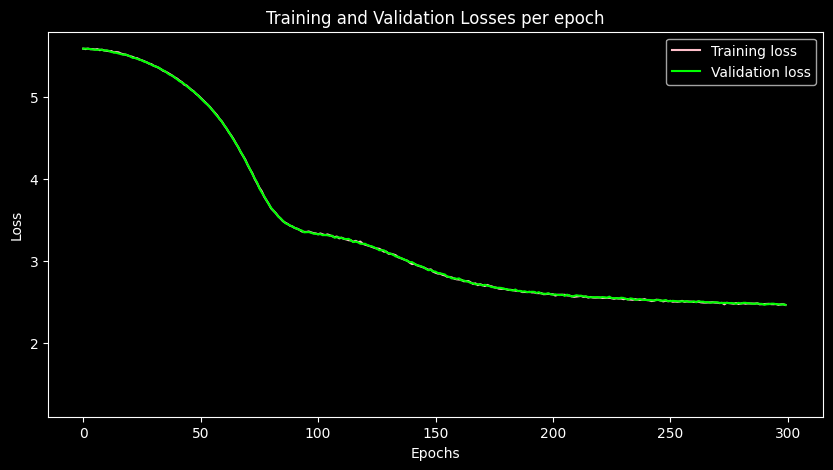

In [26]:
# Call the function
plot_losses(losses_list, ylim=[1.1, 5.8], xlim=[-15, 315])
# plot_losses(losses_list)

## Testing

In [27]:
# config.visualize = True
# print(config)

In [28]:
# Create model
model2 = MiniGPT(config)
model2.eval()
# Use nn.DataParallel to wrap the model.
# This will distribute the operations to multiple GPUs if they are available.
model2 = model2.to(config.device)
model2.load_state_dict(torch.load('./out/minigpt_state222_dict.pth'))

number of Decoder parameters: 10.65M


<All keys matched successfully>

In [29]:
context = torch.full((1, 1), tokenizer.BOS_IDX).long().to(config.device)
context = torch.zeros((1, 1), dtype=torch.long, device=config.device)

In [37]:
idx, decoder_attn_all = model2.generate(context, max_new_tokens=256)

In [38]:
print(tokenizer.encoder.decode(tokenizer.sequence_cleaner(idx[0].tolist())))


TAnd thonditr ll tIo ay odr.
Hayou&lthe.
RKF,
LBEd y, hiscyou h andath ffolid t bag nout I sthe'swimy facais ojbrisacos?

PP
Whe wIORYSHO:

Y:
T:
Muryonda r nds t t E:
Macowatro y, wave tome mesou wamilomyoully nis y othes kni, ulfe isong t Be soncaveetoru


## Attention

In [39]:
idx = torch.tensor(tokenizer.sequence_cleaner(idx[0])).unsqueeze(1)

In [40]:
input = [tokenizer.encoder.decode(i) for i in idx.tolist()]

In [41]:
attention = torch.stack(decoder_attn_all, dim=0)[:, :, :, :, :]

In [42]:
print(input)
print(len(input))
print(attention.size())

['\n', 'T', 'A', 'n', 'd', ' ', 't', 'h', 'o', 'n', 'd', 'i', 't', 'r', ' ', 'l', 'l', ' ', 't', 'I', 'o', ' ', 'a', 'y', ' ', 'o', 'd', 'r', '.', '\n', 'H', 'a', 'y', 'o', 'u', '&', 'l', 't', 'h', 'e', '.', '\n', 'R', 'K', 'F', ',', '\n', 'L', 'B', 'E', 'd', ' ', 'y', ',', ' ', 'h', 'i', 's', 'c', 'y', 'o', 'u', ' ', 'h', ' ', 'a', 'n', 'd', 'a', 't', 'h', ' ', 'f', 'f', 'o', 'l', 'i', 'd', ' ', 't', ' ', 'b', 'a', 'g', ' ', 'n', 'o', 'u', 't', ' ', 'I', ' ', 's', 't', 'h', 'e', "'", 's', 'w', 'i', 'm', 'y', ' ', 'f', 'a', 'c', 'a', 'i', 's', ' ', 'o', 'j', 'b', 'r', 'i', 's', 'a', 'c', 'o', 's', '?', '\n', '\n', 'P', 'P', '\n', 'W', 'h', 'e', ' ', 'w', 'I', 'O', 'R', 'Y', 'S', 'H', 'O', ':', '\n', '\n', 'Y', ':', '\n', 'T', ':', '\n', 'M', 'u', 'r', 'y', 'o', 'n', 'd', 'a', ' ', 'r', ' ', 'n', 'd', 's', ' ', 't', ' ', 't', ' ', 'E', ':', '\n', 'M', 'a', 'c', 'o', 'w', 'a', 't', 'r', 'o', ' ', 'y', ',', ' ', 'w', 'a', 'v', 'e', ' ', 't', 'o', 'm', 'e', ' ', 'm', 'e', 's', 'o', 'u', ' 

In [43]:
html_head_view = head_view(
    decoder_attention=attention,
    decoder_tokens=input[:-1],
    html_action='return'
)
with open("./out/minigpt_head_view.html", 'w') as file:
    file.write(html_head_view.data)